# Problem Statement

    The nature of fraud is dynamic and ever-changing. Finding patterns and identifying
    anomalies are essential in this industry. Given a set of mobile device attributes (for
    example, brand, model) data, design a model to find patterns or anomalies in these data.
    Take into account that not all device attributes are readily available all the time and there
    is no historical data available



    Summary:

    We need to develop a model that can identify patterns and anomalies in mobile device attribute data to detect potential fraud, even when data is incomplete and there's no historical information.
    
    Key Challenges:
    
        Dynamic Nature of Fraud: Fraud patterns evolve rapidly.
        Incomplete Data: Some device attributes might be missing.
        Lack of Historical Data: We cannot rely on past fraud cases for training.


In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import KNNImputer
from scipy.stats import mode
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Data Collection




In [2]:
df = pd.read_csv('/home/jovyan/shield/data/smartphone_attribute_data/smartphones - smartphones.csv')

In [3]:
df.head()

,model,price,rating,sim,processor,ram,battery,display,camera,card,os
0,OnePlus 11 5G,"₹54,999",89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor","12 GB RAM, 256 GB inbuilt",5000 mAh Battery with 100W Fast Charging,"6.7 inches, 1440 x 3216 px, 120 Hz Display wit...",50 MP + 48 MP + 32 MP Triple Rear & 16 MP Fron...,Memory Card Not Supported,Android v13
1,OnePlus Nord CE 2 Lite 5G,"₹19,989",81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 33W Fast Charging,"6.59 inches, 1080 x 2412 px, 120 Hz Display wi...",64 MP + 2 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12
2,Samsung Galaxy A14 5G,"₹16,499",75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Exynos 1330, Octa Core, 2.4 GHz Processor","4 GB RAM, 64 GB inbuilt",5000 mAh Battery with 15W Fast Charging,"6.6 inches, 1080 x 2408 px, 90 Hz Display with...",50 MP + 2 MP + 2 MP Triple Rear & 13 MP Front ...,"Memory Card Supported, upto 1 TB",Android v13
3,Motorola Moto G62 5G,"₹14,999",81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with Fast Charging,"6.55 inches, 1080 x 2400 px, 120 Hz Display wi...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12
4,Realme 10 Pro Plus,"₹24,999",82.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Dimensity 1080, Octa Core, 2.6 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 67W Fast Charging,"6.7 inches, 1080 x 2412 px, 120 Hz Display wit...",108 MP + 8 MP + 2 MP Triple Rear & 16 MP Front...,Memory Card Not Supported,Android v13


In [4]:
df.shape

(1020, 11)

In [5]:
cols_to_drop = []
cols_to_OHE = []
cols_to_transform = []

In [6]:
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   model      1020 non-null   object 
 1   price      1020 non-null   object 
 2   rating     879 non-null    float64
 3   sim        1020 non-null   object 
 4   processor  1020 non-null   object 
 5   ram        1020 non-null   object 
 6   battery    1020 non-null   object 
 7   display    1020 non-null   object 
 8   camera     1019 non-null   object 
 9   card       1013 non-null   object 
 10  os         1003 non-null   object 
dtypes: float64(1), object(10)
memory usage: 87.8+ KB


In [8]:
df.isnull().sum()

model          0
price          0
rating       141
sim            0
processor      0
ram            0
battery        0
display        0
camera         1
card           7
os            17
dtype: int64

### Observations
    ✅ There are missing values
    
    ✅ No Duplicate rows in df.

## Data Preparation

In [9]:
#### Handling Price column

df['price'] = df['price'].str.split('₹').str[1].str.replace(',','').astype(int)

In [10]:
#### Handling Sim column

df['sim'].unique()

array(['Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC',
       'Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi',
       'Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, IR Blaster',
       'Dual Sim, 3G, 4G, 5G, VoLTE, Vo5G, Wi-Fi, NFC',
       'Dual Sim, 3G, 4G, VoLTE, Wi-Fi',
       'Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Blaster',
       'Dual Sim, 3G, 4G, VoLTE, Wi-Fi, NFC',
       'Dual Sim, 3G, 4G, VoLTE, Wi-Fi, IR Blaster',
       'Dual Sim, 3G, 4G, Wi-Fi', 'Single Sim, 3G, 4G, VoLTE, Wi-Fi, NFC',
       'Single Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC',
       'Dual Sim, 3G, 4G, 5G, VoLTE, Vo5G, Wi-Fi', 'Dual Sim, 3G, 4G',
       'Single Sim, 3G, 4G, 5G, VoLTE, Wi-Fi',
       'Single Sim, 3G, 4G, Wi-Fi, NFC', 'Dual Sim, 3G, 4G, VoLTE',
       'Dual Sim, 3G, 4G, VoLTE, Wi-Fi, NFC, IR Blaster', 'Dual Sim',
       'Single Sim', 'Single Sim, 3G, 4G, VoLTE, Wi-Fi',
       'Dual Sim, 3G, Wi-Fi', 'Dual Sim, Wi-Fi',
       'Dual Sim, 3G, 4G, Wi-Fi, NFC', 'Dual Sim, 4G, VoLTE, Wi-Fi',
       'Wi-Fi', 'Dual Sim, 3G, 4

In [11]:
df['sim (dual/single)'] = df['sim'].str.split('Sim').str[0]

In [12]:
df['3G'] = np.where(df['sim'].str.contains('3G'),1,0)
df['4G'] = np.where(df['sim'].str.contains('4G'),1,0)
df['5G'] = np.where(df['sim'].str.contains('5G'),1,0)
df['VoLTE'] = np.where(df['sim'].str.contains('VoLTE'),1,0)
df['Vo5G'] = np.where(df['sim'].str.contains('Vo5G'),1,0)
df['NFC'] = np.where(df['sim'].str.contains('NFC'),1,0)
df['Wi-Fi'] = np.where(df['sim'].str.contains('Wi-Fi'),1,0)
df['IR Blaster'] = np.where(df['sim'].str.contains('IR Blaster'),1,0)

In [13]:
cols_to_drop.append('sim')

In [14]:
df['sim (dual/single)'].unique()

array(['Dual ', 'Single ', 'Wi-Fi'], dtype=object)

In [15]:
df['sim (dual/single)'].value_counts()

sim (dual/single)
Dual       998
Single      21
Wi-Fi        1
Name: count, dtype: int64

In [16]:
df[df['sim (dual/single)']=='Wi-Fi']

,model,price,rating,sim,processor,ram,battery,display,camera,card,os,sim (dual/single),3G,4G,5G,VoLTE,Vo5G,NFC,Wi-Fi,IR Blaster
754,Apple iPod Touch (7th Gen),18900,NaN,Wi-Fi,32 GB inbuilt,"4 inches, 640 x 1136 px Display",8 MP Rear & 1.2 MP Front Camera,iOS v12,No FM Radio,Bluetooth,Browser,Wi-Fi,0,0,0,0,0,0,1,0


In [17]:
df.loc[754,'sim (dual/single)' ]= "Dual "

In [18]:
df['sim (dual/single)'].value_counts()

sim (dual/single)
Dual       999
Single      21
Name: count, dtype: int64

In [19]:
df['sim (dual/single)'] = np.where(df['sim'].str.contains('Dual'),1,0)

In [20]:
df['sim (dual/single)'].value_counts()

sim (dual/single)
1    998
0     22
Name: count, dtype: int64

In [21]:
#### Handling processor columns

df['processor'].unique()

array(['Snapdragon 8 Gen2, Octa Core, 3.2\u2009GHz Processor',
       'Snapdragon 695, Octa Core, 2.2\u2009GHz Processor',
       'Exynos 1330, Octa Core, 2.4\u2009GHz Processor',
       'Snapdragon  695, Octa Core, 2.2\u2009GHz Processor',
       'Dimensity 1080, Octa Core, 2.6\u2009GHz Processor',
       'Snapdragon  750G, Octa Core, 2.2\u2009GHz Processor',
       'Bionic A15, Hexa Core, 3.22\u2009GHz Processor',
       'Snapdragon 778G Plus, Octa Core, 2.5\u2009GHz Processor',
       'Dimensity  1300, Octa Core, 3\u2009GHz Processor',
       'Dimensity 700 5G, Octa Core, 2.2\u2009GHz Processor',
       'Helio P35, Octa Core, 2.3\u2009GHz Processor',
       'Snapdragon 8+ Gen1, Octa Core, 3.2\u2009GHz Processor',
       'Dimensity 8100 Max, Octa Core, 2.85\u2009GHz Processor',
       'Helio G70, Octa Core, 2\u2009GHz Processor',
       'Snapdragon  8+ Gen1, Octa Core, 3.2\u2009GHz Processor',
       'Dimensity 1300, Octa Core, 3\u2009GHz Processor',
       'Snapdragon 695 , Octa Cor

In [22]:
df['processor']=df['processor'].str.replace('\u2009','')
df['processor_cleaned'] = np.where(df['processor'].str.contains('Processor|Octa Core|Unisoc|Bionic|Apple|Snap|Helio',na=False),df['processor'],np.nan)
df['processor_cleaned'] = np.where(df['ram'].str.contains('Processor|Octa Core|Unisoc|Bionic|Apple|Snap|Helio',na=False),df['ram'],df['processor_cleaned'])
df[df['processor_cleaned'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,sim (dual/single),3G,4G,5G,VoLTE,Vo5G,NFC,Wi-Fi,IR Blaster,processor_cleaned
473,Nokia 110 4G,1762,NaN,"Dual Sim, 3G, 4G, VoLTE",No Wifi,"128 MB RAM, 48 MB inbuilt",1020 mAh Battery,"1.8 inches, 120 x 160 px Display",0.3 MP Rear Camera,"Memory Card Supported, upto 32 GB",...,1,1,1,0,1,0,0,0,0,NaN
551,itel Magic 2 4G,2399,NaN,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi",No 3G,T117,"64 MB RAM, 128 MB inbuilt",1900 mAh Battery,"2.4 inches, 240 x 320 px Display",1.3 MP Rear Camera,...,1,1,1,0,1,0,0,1,0,NaN
573,Nokia 105 (2019),1299,NaN,Single Sim,No Wifi,"4 MB RAM, 4 MB inbuilt",800 mAh Battery,"1.77 inches, 120 x 160 px Display",No Rear Camera,NaN,...,0,0,0,0,0,0,0,0,0,NaN
608,Namotel Achhe Din,99,NaN,"Dual Sim, 3G, Wi-Fi","1GB RAM, 4GB inbuilt",1325 mAh Battery,"4 inches, 720 x 1280 px Display",2 MP Rear & 0.3 MP Front Camera,Android v5.0 (Lollipop),Bluetooth,...,1,1,0,0,0,0,0,1,0,NaN
640,Nokia 105 Plus,1299,NaN,Dual Sim,"4MB RAM, 4MB inbuilt",800 mAh Battery,"1.77 inches, 128 x 160 px Display",No Rear Camera,"Memory Card Supported, upto 32 GB",Bluetooth,...,1,0,0,0,0,0,0,0,0,NaN
645,Nokia 2760 Flip,5490,NaN,"Dual Sim, 3G, 4G, Wi-Fi",1450mAh Battery,"3.6 inches, 240 x 320 px Display",5 MP Rear & 5 MP Front Camera,"Memory Card Supported, upto 32 GB",Kaios v3.0,Bluetooth,...,1,1,1,0,0,0,0,1,0,NaN
647,Motorola Moto A10,1339,NaN,Dual Sim,"4MB RAM, 4MB inbuilt",1750 mAh Battery,"1.8 inches, 160 x 128 px Display",No Rear Camera,"Memory Card Supported, upto 32 GB",NaN,...,1,0,0,0,0,0,0,0,0,NaN
657,Zanco Tiny T1,2799,NaN,Single Sim,"32MB RAM, 32MB inbuilt",200 mAh Battery,"0.49 inches, 64 x 32 px Display",No Rear Camera,No FM Radio,Bluetooth,...,0,0,0,0,0,0,0,0,0,NaN
665,itel it2163S,958,NaN,Dual Sim,"4MB RAM, 4MB inbuilt",1200 mAh Battery,"1.8 inches, 160 x 128 px Display",No Rear Camera,"Memory Card Supported, upto 32 GB",Bluetooth,...,1,0,0,0,0,0,0,0,0,NaN
699,Samsung Guru GT-E1215,1850,NaN,Single Sim,800mAh Battery,"1.5 inches, 120 x 120 px Display",No Rear Camera,No FM Radio,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN


In [23]:
dict(df['processor_cleaned'].value_counts())

{'Dimensity 700 5G, Octa Core, 2.2GHz Processor': 29,
 'Helio P35, Octa Core, 2.3GHz Processor': 27,
 'Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor': 26,
 'Snapdragon 680, Octa Core, 2.4GHz Processor': 23,
 'Snapdragon 695, Octa Core, 2.2GHz Processor': 23,
 'Snapdragon 8 Gen2, Octa Core, 3.2GHz Processor': 23,
 'Helio G35, Octa Core, 2.3GHz Processor': 20,
 'Snapdragon  680, Octa Core, 2.4GHz Processor': 18,
 'Snapdragon  8 Gen1, Octa Core, 3GHz Processor': 18,
 'Snapdragon 8 Gen1, Octa Core, 3GHz Processor': 17,
 'Bionic A15, Hexa Core, 3.22GHz Processor': 16,
 'Snapdragon  695, Octa Core, 2.2GHz Processor': 16,
 'Dimensity  810 5G, Octa Core, 2.4GHz Processor': 15,
 'Snapdragon 870, Octa Core, 3.2GHz Processor': 15,
 'Helio G80, Octa Core, 2GHz Processor': 14,
 'Helio G99, Octa Core, 2.2GHz Processor': 14,
 'Helio G96, Octa Core, 2.05GHz Processor': 12,
 'Snapdragon 778G, Octa Core, 2.4GHz Processor': 12,
 'Dimensity 810 5G, Octa Core, 2.4GHz Processor': 12,
 'Dimensity 1080, Oct

In [24]:
# Define regex pattern for known processor types
processor_patterns = [
    r'Bionic', 
    r'Dimensity', 
    r'Exynos', 
    r'Snapdragon', 
    r'Unisoc', 
    r'Kirin', 
    r'Ryzen', 
    r'Google Tensor',
    r'Helio',
    r'Kirin',
    r'Spreadtrum',
    r'Tiger',
    r'Unisoc'
]

def extract_processor(processor_name):
    if not isinstance(processor_name, str) or not processor_name.strip():
        return "Unknown"
    for pattern in processor_patterns:
        if re.search(pattern, processor_name, re.IGNORECASE):
            return pattern  # Return the matched processor type
    return "Unknown"

# Apply function to extract processor type
df['Processor_Type'] = df['processor_cleaned'].apply(extract_processor)

In [25]:
df['Processor_Type'].value_counts()

Processor_Type
Snapdragon       413
Helio            202
Dimensity        177
Unknown           65
Exynos            50
Bionic            44
Unisoc            31
Tiger             24
Kirin              7
Spreadtrum         4
Google Tensor      3
Name: count, dtype: int64

In [26]:
df['Processor_Type'].isnull().sum()

0

In [27]:
# Count the Processor_Type of each OS
processor_counts = df['Processor_Type'].value_counts()

# Replace Processor_Type names with "Other" if their count is less than 30
df['Processor_Type'] = df['Processor_Type'].apply(lambda x: x if processor_counts[x] >= 30 else "Other")

In [28]:
df['Processor_Type'].value_counts()

Processor_Type
Snapdragon    413
Helio         202
Dimensity     177
Unknown        65
Exynos         50
Bionic         44
Other          38
Unisoc         31
Name: count, dtype: int64

In [29]:
# Function to extract core type

def extract_core_type(processor_name):
    if not isinstance(processor_name, str) or not processor_name.strip():
        return "Unknown"
    match = re.search(r'\b(Octa|Hexa|Quad) Core\b', processor_name, re.IGNORECASE)
    return match.group(1) if match else 'Unknown'

df['Core_Type'] = df['processor_cleaned'].apply(extract_core_type)

In [30]:
df['Core_Type'].value_counts()

Core_Type
Octa       899
Unknown     43
Hexa        39
Quad        39
Name: count, dtype: int64

In [31]:
df['Core_Type'].isnull().sum()

0

In [32]:
cols_to_drop.extend(["processor_cleaned","processor"])

In [33]:
cols_to_OHE.extend(["Processor_Type","Core_Type"])

In [34]:
#### Handling Model columns


# Extract brand name (First word of the mobile name)
# Extract brand name after stripping leading/trailing spaces
df["Brand"] = df["model"].apply(lambda x: str(x).strip().split()[0])

# Count occurrences of each brand
brand_counts = df["Brand"].value_counts()

# Replace brands with frequency < 10 as "Other"
df["Brand"] = df["Brand"].apply(lambda x: x if brand_counts[x] >= 10 else "Other")

# Display the updated DataFrame
print(df[["model", "Brand"]].head())

                       model     Brand
0              OnePlus 11 5G   OnePlus
1  OnePlus Nord CE 2 Lite 5G   OnePlus
2      Samsung Galaxy A14 5G   Samsung
3       Motorola Moto G62 5G  Motorola
4         Realme 10 Pro Plus    Realme


In [35]:
df["Brand"].isnull ().sum ()

0

In [37]:
df["Brand"].value_counts()

Brand
Xiaomi      135
Samsung     135
Vivo        111
Realme       97
Other        93
OPPO         62
Motorola     53
Apple        47
OnePlus      42
Tecno        33
iQOO         32
Nokia        30
Infinix      29
Poco         28
Oppo         26
Huawei       16
Google       14
POCO         13
Honor        13
itel         11
Name: count, dtype: int64

In [36]:
# Drop the 'model' column
cols_to_drop.append("model")
cols_to_OHE.append("Brand")

In [38]:
#### Handling ram column

df['ram'].unique()

array(['12\u2009GB RAM, 256\u2009GB inbuilt',
       '6\u2009GB RAM, 128\u2009GB inbuilt',
       '4\u2009GB RAM, 64\u2009GB inbuilt',
       '8\u2009GB RAM, 256\u2009GB inbuilt',
       '8\u2009GB RAM, 128\u2009GB inbuilt',
       '4\u2009GB RAM, 128\u2009GB inbuilt',
       '3\u2009GB RAM, 32\u2009GB inbuilt',
       '16\u2009GB RAM, 256\u2009GB inbuilt',
       '6\u2009GB RAM, 64\u2009GB inbuilt',
       '4\u2009GB RAM, 32\u2009GB inbuilt',
       '3\u2009GB RAM, 64\u2009GB inbuilt',
       '2\u2009GB RAM, 32\u2009GB inbuilt',
       '16\u2009GB RAM, 512\u2009GB inbuilt',
       '2\u2009GB RAM, 64\u2009GB inbuilt',
       '4\u2009GB RAM, 512\u2009MB inbuilt',
       '6\u2009GB RAM, 256\u2009GB inbuilt',
       '12\u2009GB RAM, 128\u2009GB inbuilt',
       '512\u2009MB RAM, 4\u2009GB inbuilt',
       '18\u2009GB RAM, 512\u2009GB inbuilt',
       '6\u2009GB RAM, 1\u2009TB inbuilt',
       '12\u2009GB RAM, 512\u2009GB inbuilt',
       '4\u2009GB RAM, 256\u2009GB inbuilt', 'Unisoc T107'

In [39]:
df['ram'] = df['ram'].str.replace('\u2009','')
df['ram_new'] = np.where(df['ram'].str.contains('RAM'),df['ram'],np.nan)
df['ram_new'] = np.where(df['ram_new'].isnull() & df['battery'].str.contains('RAM'),df['battery'], df['ram_new'])
df['ram_new'] = np.where(df['ram_new'].isnull() & df['processor'].str.contains('RAM'),df['processor'], df['ram_new'])

In [40]:
df['ram_new'].value_counts()

ram_new
8GB RAM, 128GB inbuilt       267
6GB RAM, 128GB inbuilt       190
4GB RAM, 64GB inbuilt        143
12GB RAM, 256GB inbuilt       70
8GB RAM, 256GB inbuilt        70
4GB RAM, 128GB inbuilt        62
3GB RAM, 32GB inbuilt         37
6GB RAM, 64GB inbuilt         29
2GB RAM, 32GB inbuilt         24
3GB RAM, 64GB inbuilt         15
12GB RAM, 512GB inbuilt       10
6GB RAM, 256GB inbuilt         7
1GB RAM, 16GB inbuilt          6
16GB RAM, 256GB inbuilt        6
4GB RAM, 32GB inbuilt          6
4MB RAM, 4MB inbuilt           5
6GB RAM, 1TB inbuilt           4
2GB RAM, 16GB inbuilt          4
6GB RAM, 512GB inbuilt         4
48 MB RAM, 128 MB inbuilt      4
12GB RAM, 128GB inbuilt        4
2GB RAM, 64GB inbuilt          4
16GB RAM, 512GB inbuilt        3
1GB RAM, 8GB inbuilt           3
512MB RAM, 4GB inbuilt         3
64MB RAM, 128MB inbuilt        3
32MB RAM, 32MB inbuilt         3
4GB RAM, 256GB inbuilt         3
8GB RAM, 512GB inbuilt         2
8MB RAM, 16MB inbuilt          2
32

In [41]:
df['ram_new'].isnull().sum()

10

In [42]:
df[df['ram_new'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,VoLTE,Vo5G,NFC,Wi-Fi,IR Blaster,processor_cleaned,Processor_Type,Core_Type,Brand,ram_new
439,Apple iPhone SE 3 2022,43900,NaN,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A15, Hexa Core, 3.22GHz Processor",64GB inbuilt,"4.7 inches, 750 x 1334 px Display",12 MP Rear & 7 MP Front Camera,Memory Card Not Supported,iOS v15,...,1,0,1,1,0,"Bionic A15, Hexa Core, 3.22GHz Processor",Bionic,Hexa,Apple,NaN
483,Huawei Mate 50 RS Porsche Design,239999,81.0,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi, NFC, IR Blaster","Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor",512GB inbuilt,4700 mAh Battery with 66W Fast Charging,"6.74 inches, 1212 x 2616 px, 120 Hz Display",50 MP + 48 MP + 13 MP Triple Rear & 13 MP Fron...,"Memory Card (Hybrid), upto 256 GB",...,1,0,1,1,1,"Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor",Snapdragon,Octa,Huawei,NaN
532,Samsung Guru Music 2 Dual Sim,1949,NaN,Dual Sim,No Wifi,"Single Core, 208MHz Processor",800 mAh Battery,"2 inches, 128 x 160 px Display",No Rear Camera,"Memory Card Supported, upto 16 GB",...,0,0,0,0,0,"Single Core, 208 MHz Processor",Unknown,Unknown,Samsung,NaN
645,Nokia 2760 Flip,5490,NaN,"Dual Sim, 3G, 4G, Wi-Fi",1450mAh Battery,"3.6 inches, 240x320px Display",5 MP Rear & 5 MP Front Camera,"Memory Card Supported, upto 32 GB",Kaios v3.0,Bluetooth,...,0,0,0,1,0,NaN,Unknown,Unknown,Nokia,NaN
699,Samsung Guru GT-E1215,1850,NaN,Single Sim,800mAh Battery,"1.5 inches, 120x120px Display",No Rear Camera,No FM Radio,NaN,NaN,...,0,0,0,0,0,NaN,Unknown,Unknown,Samsung,NaN
748,Nokia 400 4G,3290,NaN,"Dual Sim, 4G, VoLTE, Wi-Fi",2000mAh Battery,"2.4 inches, 240x320px Display",0.3 MP Rear & 0.3 MP Front Camera,"Memory Card Supported, upto 64 GB",Bluetooth,Browser,...,1,0,0,1,0,NaN,Unknown,Unknown,Nokia,NaN
754,Apple iPod Touch (7th Gen),18900,NaN,Wi-Fi,32GB inbuilt,"4 inches, 640x1136px Display",8 MP Rear & 1.2 MP Front Camera,iOS v12,No FM Radio,Bluetooth,...,0,0,0,1,0,NaN,Unknown,Unknown,Apple,NaN
762,Apple iPhone SE 4,49990,60.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A15, Hexa Core, 3.22GHz Processor",64GB inbuilt,"6.1 inches, 750 x 1580 px Display",12 MP Rear & 10.8 MP Front Camera,Memory Card Not Supported,iOS v16,...,1,0,1,1,0,"Bionic A15, Hexa Core, 3.22GHz Processor",Bionic,Hexa,Apple,NaN
917,Nokia 150 (2020),2499,NaN,Dual Sim,No Wifi,4MB inbuilt,1020 mAh Battery,"2.4 inches, 240 x 320 px Display",0.3 MP Rear Camera,"Memory Card Supported, upto 32 GB",...,0,0,0,0,0,NaN,Unknown,Unknown,Nokia,NaN
927,Samsung Guru E1200,1685,NaN,Single Sim,No Wifi,800mAh Battery,"1.5 inches, 128 x 128 px Display",No Rear Camera,No FM Radio,NaN,...,0,0,0,0,0,NaN,Unknown,Unknown,Samsung,NaN


In [43]:
df.loc[[439, 483,917,762], 'ram_new'] = df.loc[[439, 483,917,762], 'ram']
df.loc[[754], 'ram_new'] = df.loc[[754], 'processor']

In [44]:
df[df['ram_new'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,VoLTE,Vo5G,NFC,Wi-Fi,IR Blaster,processor_cleaned,Processor_Type,Core_Type,Brand,ram_new
532,Samsung Guru Music 2 Dual Sim,1949,NaN,Dual Sim,No Wifi,"Single Core, 208MHz Processor",800 mAh Battery,"2 inches, 128 x 160 px Display",No Rear Camera,"Memory Card Supported, upto 16 GB",...,0,0,0,0,0,"Single Core, 208 MHz Processor",Unknown,Unknown,Samsung,NaN
645,Nokia 2760 Flip,5490,NaN,"Dual Sim, 3G, 4G, Wi-Fi",1450mAh Battery,"3.6 inches, 240x320px Display",5 MP Rear & 5 MP Front Camera,"Memory Card Supported, upto 32 GB",Kaios v3.0,Bluetooth,...,0,0,0,1,0,NaN,Unknown,Unknown,Nokia,NaN
699,Samsung Guru GT-E1215,1850,NaN,Single Sim,800mAh Battery,"1.5 inches, 120x120px Display",No Rear Camera,No FM Radio,NaN,NaN,...,0,0,0,0,0,NaN,Unknown,Unknown,Samsung,NaN
748,Nokia 400 4G,3290,NaN,"Dual Sim, 4G, VoLTE, Wi-Fi",2000mAh Battery,"2.4 inches, 240x320px Display",0.3 MP Rear & 0.3 MP Front Camera,"Memory Card Supported, upto 64 GB",Bluetooth,Browser,...,1,0,0,1,0,NaN,Unknown,Unknown,Nokia,NaN
927,Samsung Guru E1200,1685,NaN,Single Sim,No Wifi,800mAh Battery,"1.5 inches, 128 x 128 px Display",No Rear Camera,No FM Radio,NaN,...,0,0,0,0,0,NaN,Unknown,Unknown,Samsung,NaN


In [45]:
import re

# Function to extract RAM and Inbuilt Memory
def extract_ram_memory(value):
    match = re.findall(r'([\d]+(?:GB|MB|TB)) RAM, ([\d]+(?:GB|MB|TB)) inbuilt', str(value))
    return match[0] if match else (None, None)

# Apply function to create new columns
df[['RAM', 'Inbuilt_Memory']] = df['ram_new'].apply(lambda x: pd.Series(extract_ram_memory(x)))

# Display the updated DataFrame
print(df[['RAM', 'Inbuilt_Memory']].head())

    RAM Inbuilt_Memory
0  12GB          256GB
1   6GB          128GB
2   4GB           64GB
3   6GB          128GB
4   6GB          128GB


In [46]:
df['RAM'].isnull().sum()

17

In [47]:
df['RAM'].value_counts()

RAM
8GB      339
6GB      234
4GB      216
12GB      85
3GB       54
2GB       32
1GB       10
16GB       9
4MB        5
512MB      3
64MB       3
32MB       3
18GB       2
8MB        2
48MB       2
128MB      1
52MB       1
256MB      1
16MB       1
Name: count, dtype: int64

In [48]:
# Convert RAM values with MB to "<1GB"
df['RAM'] = df['RAM'].apply(lambda x: "<1GB" if "MB" in str(x) else x)

In [49]:
df['RAM'].value_counts()

RAM
8GB     339
6GB     234
4GB     216
12GB     85
3GB      54
2GB      32
<1GB     22
1GB      10
16GB      9
18GB      2
Name: count, dtype: int64

In [50]:
# Function to categorize RAM

def categorize_ram(ram):

    if ram == "<1GB":
        return "<1GB"
    if pd.isna(ram):  # Handle NaN values
        return "Unknown"
    mp = str(ram).strip()  
    try:
        value = int(ram.replace("GB", ""))  # Remove 'GB' and leading zeros
        if 1 <= value <= 8:
            return "1-8"
        elif 9 <= value <= 16:
            return "9-16"
        elif 17 <= value <= 24:
            return "17-24"
        else:
            return ">24"
    except ValueError:
        return "Unknown"

# Apply categorization
df["RAM"] = df["RAM"].apply(categorize_ram)

In [51]:
df["RAM"].value_counts()

RAM
1-8        885
9-16        94
<1GB        22
Unknown     17
17-24        2
Name: count, dtype: int64

In [52]:
df['Inbuilt_Memory'].isnull().sum()

17

In [53]:
df['Inbuilt_Memory'].value_counts()

Inbuilt_Memory
128GB    523
64GB     191
256GB    157
32GB      67
512GB     21
16GB      12
1TB        5
4MB        5
4GB        4
128MB      4
32MB       4
8GB        3
16MB       3
512MB      2
48MB       2
Name: count, dtype: int64

In [54]:
# Convert RAM values with MB to "<1GB"
df['Inbuilt_Memory'] = df['Inbuilt_Memory'].apply(lambda x: "<1GB" if "MB" in str(x) else x)

In [55]:
df['Inbuilt_Memory'].value_counts()

Inbuilt_Memory
128GB    523
64GB     191
256GB    157
32GB      67
512GB     21
<1GB      20
16GB      12
1TB        5
4GB        4
8GB        3
Name: count, dtype: int64

In [56]:
# Function to categorize Inbuilt Memory
def categorize_memory(memory):
    value = None
    if pd.isna(memory):  # Handle NaN values
        return "Unknown"
    
    memory = str(memory).strip()  # Convert to string and remove whitespace

    if memory == "<1GB":
        return "<1GB"
    
    try:
        if "GB" in memory:
            value = int(memory.replace("GB", "").lstrip("0"))  # Remove 'GB' and leading zeros
        elif "TB" in memory:
            value = int(memory.replace("TB", "").lstrip("0")) * 1024  # Convert TB to GB
            
        if value is None:
            return "Unknown"
            
        if 1 <= value <= 48:
            return "1-48GB"
        elif 49 <= value <= 128:
            return "49-128GB"
        elif 129 <= value <= 256:
            return "129-256GB"
        elif 257 <= value <= 512:
            return "257-512GB"
        else:
            return ">512GB"
    except ValueError:
        return "Unknown"

# Apply categorization
df["Inbuilt_Memory"] = df["Inbuilt_Memory"].apply(categorize_memory)

In [57]:
df["Inbuilt_Memory"].value_counts()

Inbuilt_Memory
49-128GB     714
129-256GB    157
1-48GB        86
257-512GB     21
<1GB          20
Unknown       17
>512GB         5
Name: count, dtype: int64

In [58]:
cols_to_drop.extend(["ram","ram_new"])

In [59]:
cols_to_OHE.extend(["RAM","Inbuilt_Memory"])

In [60]:
#### Handling Battery column

df['battery'].str.split('with').str[0].unique()

array(['5000\u2009mAh Battery ', '3279\u2009mAh Battery ',
       '4980\u2009mAh Battery ', '4500\u2009mAh Battery ',
       '3240\u2009mAh Battery ', '4700\u2009mAh Battery ',
       '4830\u2009mAh Battery ', '4800\u2009mAh Battery ',
       '4323\u2009mAh Battery ', '3110\u2009mAh Battery',
       '5200\u2009mAh Battery ', '6000\u2009mAh Battery ',
       '5000\u2009mAh Battery', '4325\u2009mAh Battery ',
       '4600\u2009mAh Battery ', '4200\u2009mAh Battery ',
       '3500\u2009mAh Battery', '3095\u2009mAh Battery ',
       '4020\u2009mAh Battery ', '3200\u2009mAh Battery ',
       '4400\u2009mAh Battery ', '4310\u2009mAh Battery ',
       '4820\u2009mAh Battery ', '3700\u2009mAh Battery ',
       '5160\u2009mAh Battery ',
       '6.1 inches, 1170\u2009x\u20092532\u2009px Display ',
       '5080\u2009mAh Battery ', '3900\u2009mAh Battery ',
       '4410\u2009mAh Battery ', '5020\u2009mAh Battery ',
       '2800\u2009mAh Battery',
       '5.4 inches, 1080\u2009x\u20092340\u2009px D

In [61]:
df['battery']=df['battery'].str.replace('\u2009','')
df['battery_cleaned'] = np.where(df['battery'].str.contains('mAh'),df['battery'],np.nan)
df['battery_cleaned'] = np.where(df['display'].str.contains('mAh'),df['display'],df['battery_cleaned'])
df['battery_cleaned'] = np.where(df['processor'].str.contains('mAh'),df['processor'],df['battery_cleaned'])
df['battery_cleaned'] = np.where(df['ram'].str.contains('mAh'),df['ram'],df['battery_cleaned'])
df['battery in mAh'] = np.where(df['battery_cleaned'].str.contains('mAh'),df['battery_cleaned'].str.split('mAh').str[0],np.nan)
df['battery in mAh'] = df['battery in mAh'].str.replace('\u2009', "")
df['battery in mAh'].isnull().sum()

12

In [62]:
df['battery_cleaned'].value_counts()

battery_cleaned
5000mAh Battery with 33W Fast Charging      103
5000mAh Battery with 18W Fast Charging       89
5000mAh Battery                              74
5000mAh Battery with 67W Fast Charging       30
5000mAh Battery with 10W Fast Charging       28
                                           ... 
4700mAh Battery with 33W Fast Charging        1
5000mAh Battery with 19W Fast Charging        1
5160mAh Battery with 33W Fast Charging        1
2275mAh Battery                               1
5000mAh Battery with 68.2W Fast Charging      1
Name: count, Length: 246, dtype: int64

In [63]:
df['battery in mAh'].unique()

array(['5000', '3279', '4980', '4500', '3240', '4700', '4830', '4800',
       '4323', '3110', '5200', '6000', '4325', '4600', '4200', '3500',
       '3095', '4020', '3200', '4400', '4310', '4820', '3700', '5160',
       nan, '5080', '3900', '4410', '5020', '2800', '4352', '1450',
       '4520', '4810', '4000', '2050', '2150', '4610', '5100', '7000',
       '4300', '5500', '4050', '4355', '3060', '1500', '5003', '2438',
       '4250', '3300', '4450', '4614', '4870', '4030', '4350', '4100',
       '21000', '2000', '4860', '2275', '4230', '1020', '1900', '3020',
       '4730', '3520', '4080', '800', '2500', '5050', '5600', '4470',
       '3360', '3000', '2230', '1325', '9800', '1150', '1750', '1821',
       '200', '1200', '1480', '4015', '3285', '4360', '1000', '3315',
       '1470', '3600', '3100', '22000', '2400', '4532', '1800', '5065',
       '4620', '4780', '3730', '3400', '2730', '5180', '8000'],
      dtype=object)

In [64]:
df['battery in mAh'] = df['battery in mAh'].astype('Int64')

In [68]:
list(df['battery in mAh'].unique())

[5000,
 3279,
 4980,
 4500,
 3240,
 4700,
 4830,
 4800,
 4323,
 3110,
 5200,
 6000,
 4325,
 4600,
 4200,
 3500,
 3095,
 4020,
 3200,
 4400,
 4310,
 4820,
 3700,
 5160,
 <NA>,
 5080,
 3900,
 4410,
 5020,
 2800,
 4352,
 1450,
 4520,
 4810,
 4000,
 2050,
 2150,
 4610,
 5100,
 7000,
 4300,
 5500,
 4050,
 4355,
 3060,
 1500,
 5003,
 2438,
 4250,
 3300,
 4450,
 4614,
 4870,
 4030,
 4350,
 4100,
 21000,
 2000,
 4860,
 2275,
 4230,
 1020,
 1900,
 3020,
 4730,
 3520,
 4080,
 800,
 2500,
 5050,
 5600,
 4470,
 3360,
 3000,
 2230,
 1325,
 9800,
 1150,
 1750,
 1821,
 200,
 1200,
 1480,
 4015,
 3285,
 4360,
 1000,
 3315,
 1470,
 3600,
 3100,
 22000,
 2400,
 4532,
 1800,
 5065,
 4620,
 4780,
 3730,
 3400,
 2730,
 5180,
 8000]

In [69]:
df['battery in mAh'].isnull().sum()

12

In [84]:
def categorize_batterymAh(mAh):

    if pd.isna(mAh):  # Handle NaN values
        return "Unknown"
    try:
        if mAh <= 2000:
            return "<2000mAh"
        elif 2001 <= mAh <= 4000:
            return "2001-4000mAh"
        elif 4001 <= mAh <= 6000:
            return "4001-6000mAh"
        elif 6001 <= mAh <= 10000:
            return "6001-10000mAh"
        elif mAh > 10001:
            return ">10000mAh"
        else:
            return "Unknown"
    except ValueError:
        return "Unknown"

# Apply categorization
df["battery in mAh"] = df["battery in mAh"].apply(categorize_batterymAh)

In [85]:
df["battery in mAh"].value_counts()

battery in mAh
4001-6000mAh     857
2001-4000mAh     102
<2000mAh          39
Unknown           12
6001-10000mAh      8
>10000mAh          2
Name: count, dtype: int64

In [86]:
cols_to_drop.extend(["battery","battery_cleaned"])
cols_to_OHE.append('battery in mAh')

In [71]:
df['charger'] = np.where(df['battery_cleaned'].str.contains('mAh'),df['battery_cleaned'].str.split('mAh').str[1],np.nan)

In [87]:
df['charger'].isnull().sum()

12

In [73]:
df['charger'].value_counts()

charger
 Battery                             171
 Battery with 33W Fast Charging      152
 Battery with 18W Fast Charging      128
 Battery with Fast Charging           68
 Battery with 67W Fast Charging       65
 Battery with 25W Fast Charging       53
 Battery with 120W Fast Charging      46
 Battery with 15W Fast Charging       43
 Battery with 80W Fast Charging       42
 Battery with 66W Fast Charging       37
 Battery with 10W Fast Charging       33
 Battery with 30W Fast Charging       32
 Battery with 65W Fast Charging       30
 Battery with 44W Fast Charging       23
 Battery with 45W Fast Charging       17
 Battery with 20W Fast Charging       10
 Battery with 100W Fast Charging       7
 Battery with 68W Fast Charging        7
 Battery with 150W Fast Charging       7
 Battery with 125W Fast Charging       6
 Battery with 40W Fast Charging        5
 Battery with 22.5W Fast Charging      5
 Battery with 60W Fast Charging        4
 Battery with 55W Fast Charging        3
 Battery

In [75]:
# Function to extract the number before 'W'
def extract_wattage(value):
    if not isinstance(value, str) or not value.strip():
        return None
    match = re.search(r'(\d+\.?\d*)W', value)
    return float(match.group(1)) if match else None

# Apply function
df['Wattage'] = df['charger'].apply(extract_wattage)

In [76]:
df['Wattage'].value_counts()

Wattage
33.0     152
18.0     128
67.0      65
25.0      53
120.0     46
15.0      43
80.0      42
66.0      37
10.0      33
30.0      32
65.0      30
44.0      23
45.0      17
20.0      10
68.0       7
100.0      7
150.0      7
125.0      6
22.5       5
40.0       5
60.0       4
55.0       3
21.0       2
50.0       2
210.0      2
240.0      1
19.0       1
200.0      1
135.0      1
165.0      1
180.0      1
27.0       1
68.2       1
Name: count, dtype: int64

In [78]:
df['Wattage'].isnull().sum()

251

In [80]:
def categorize_wattage(wattage):

    if pd.isna(wattage):  # Handle NaN values
        return "Unknown"
    try:
        if 1 <= wattage <= 25:
            return "<25W"
        elif 26 <= wattage <= 50:
            return "25-50W"
        elif 51 <= wattage <= 100:
            return "51-100W"
        elif 101 <= wattage <= 150:
            return "101-150W"
        elif wattage > 150:
            return ">150W"
        else:
            return "Unknown"
    except ValueError:
        return "Unknown"

# Apply categorization
df["Wattage"] = df["Wattage"].apply(categorize_wattage)

In [88]:
df["Wattage"].value_counts()

Wattage
<25W        275
Unknown     251
25-50W      232
51-100W     196
101-150W     60
>150W         6
Name: count, dtype: int64

In [83]:
cols_to_drop.append("charger")
cols_to_OHE.append("Wattage")

In [90]:
cols_to_drop

['sim',
 'processor_cleaned',
 'processor',
 'model',
 'ram',
 'ram_new',
 'battery',
 'battery_cleaned',
 'charger',
 'battery',
 'battery_cleaned']

In [92]:
#### Handle display column

df['display'].unique()

array(['6.7 inches, 1440\u2009x\u20093216\u2009px, 120 Hz Display with Punch Hole',
       '6.59 inches, 1080\u2009x\u20092412\u2009px, 120 Hz Display with Punch Hole',
       '6.6 inches, 1080\u2009x\u20092408\u2009px, 90 Hz Display with Water Drop Notch',
       '6.55 inches, 1080\u2009x\u20092400\u2009px, 120 Hz Display with Punch Hole',
       '6.7 inches, 1080\u2009x\u20092412\u2009px, 120 Hz Display with Punch Hole',
       '6.6 inches, 1080\u2009x\u20092408\u2009px, 120 Hz Display with Water Drop Notch',
       '6.1 inches, 1170\u2009x\u20092532\u2009px Display with Small Notch',
       '6.67 inches, 1080\u2009x\u20092400\u2009px, 120 Hz Display with Punch Hole',
       '6.43 inches, 1080\u2009x\u20092400\u2009px, 90 Hz Display with Punch Hole',
       '6.72 inches, 1080\u2009x\u20092400\u2009px, 120 Hz Display with Punch Hole',
       '6.56 inches, 720\u2009x\u20091612\u2009px, 90 Hz Display with Water Drop Notch',
       '6.58 inches, 1080\u2009x\u20092408\u2009px, 120 Hz Disp

In [93]:
df['display'] = df['display'].str.replace('\u2009', "")
df['display_cleaned'] = np.where(df['display'].str.contains('inches|Display',na=False),df['display'],np.nan)
df[df['display_cleaned'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,Core_Type,Brand,ram_new,RAM,Inbuilt_Memory,battery_cleaned,battery in mAh,charger,Wattage,display_cleaned
111,Apple iPhone 12,51999,74.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A14, Hexa Core, 3.1GHz Processor","4GB RAM, 64GB inbuilt","6.1 inches, 1170x2532px Display with Large Notch",12MP + 12MP Dual Rear & 12MP Front Camera,Memory Card Not Supported,iOS v14,...,Hexa,Apple,"4GB RAM, 64GB inbuilt",1-8,49-128GB,NaN,Unknown,NaN,Unknown,NaN
149,Apple iPhone 12 Mini,40999,74.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A14, Hexa Core, 3.1GHz Processor","4GB RAM, 64GB inbuilt","5.4 inches, 1080x2340px Display",12MP + 12MP Dual Rear & 12MP Front Camera,Memory Card Not Supported,iOS v14,...,Hexa,Apple,"4GB RAM, 64GB inbuilt",1-8,49-128GB,NaN,Unknown,NaN,Unknown,NaN
307,Apple iPhone 12 (128GB),55999,75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A14, Hexa Core, 3.1GHz Processor","4GB RAM, 128GB inbuilt","6.1 inches, 1170x2532px Display with Large Notch",12MP + 12MP Dual Rear & 12MP Front Camera,Memory Card Not Supported,iOS v14,...,Hexa,Apple,"4GB RAM, 128GB inbuilt",1-8,49-128GB,NaN,Unknown,NaN,Unknown,NaN
363,Apple iPhone 12 Mini (128GB),45999,75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A14, Hexa Core, 3.1GHz Processor","4GB RAM, 128GB inbuilt","5.4 inches, 1080x2340px Display",12MP + 12MP Dual Rear & 12MP Front Camera,Memory Card Not Supported,iOS v14,...,Hexa,Apple,"4GB RAM, 128GB inbuilt",1-8,49-128GB,NaN,Unknown,NaN,Unknown,NaN
376,Nokia 2660 Flip,4649,NaN,"Dual Sim, 3G, 4G",No Wifi,Unisoc T107,"48MB RAM, 128MB inbuilt",1450mAh Battery,"2.8 inches, 240 x 320 px Display",Dual Display,...,Unknown,Nokia,"48 MB RAM, 128 MB inbuilt",Unknown,Unknown,1450 mAh Battery,<2000mAh,Battery,Unknown,NaN
439,Apple iPhone SE 3 2022,43900,NaN,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A15, Hexa Core, 3.22GHz Processor",64GB inbuilt,"4.7 inches, 750x1334px Display",12MP Rear & 7MP Front Camera,Memory Card Not Supported,iOS v15,...,Hexa,Apple,64GB inbuilt,Unknown,Unknown,NaN,Unknown,NaN,Unknown,NaN
448,Apple iPhone 15 Pro,130990,75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC",Bionic A16,"8GB RAM, 128GB inbuilt","6.06 inches, 1170x2532px, 120 Hz Display with ...",50MP + 12MP + 12MP Triple Rear & 12MP Front Ca...,Memory Card Not Supported,iOS v15,...,Unknown,Apple,"8GB RAM, 128GB inbuilt",1-8,49-128GB,NaN,Unknown,NaN,Unknown,NaN
551,itel Magic 2 4G,2399,NaN,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi",No 3G,T117,"64MB RAM, 128MB inbuilt",1900mAh Battery,"2.4 inches, 240 x 320 px Display",1.3 MP Rear Camera,...,Unknown,itel,"64 MB RAM, 128 MB inbuilt",Unknown,Unknown,1900 mAh Battery,<2000mAh,Battery,Unknown,NaN
582,Nokia 8210 4G,3749,NaN,"Dual Sim, 3G, 4G",No Wifi,Unisoc T107,"48MB RAM, 128MB inbuilt",1450mAh Battery,"2.8 inches, 240 x 320 px Display",0.3 MP Rear Camera,...,Unknown,Nokia,"48 MB RAM, 128 MB inbuilt",Unknown,Unknown,1450 mAh Battery,<2000mAh,Battery,Unknown,NaN
608,Namotel Achhe Din,99,NaN,"Dual Sim, 3G, Wi-Fi","1GB RAM, 4GB inbuilt",1325mAh Battery,"4 inches, 720x1280px Display",2MP Rear & 0.3MP Front Camera,Android v5.0 (Lollipop),Bluetooth,...,Unknown,Other,"1GB RAM, 4GB inbuilt",1-8,1-48GB,1325mAh Battery,<2000mAh,Battery,Unknown,NaN


In [94]:
dict(df['display_cleaned'].value_counts())

{'6.67 inches, 1080x2400px, 120 Hz Display with Punch Hole': 54,
 '6.5 inches, 720x1600px Display with Water Drop Notch': 36,
 '6.7 inches, 1080x2412px, 120 Hz Display with Punch Hole': 25,
 '6.52 inches, 720x1600px Display with Water Drop Notch': 23,
 '6.5 inches, 1080x2400px, 90 Hz Display with Punch Hole': 22,
 '6.51 inches, 720x1600px Display with Water Drop Notch': 21,
 '6.43 inches, 1080x2400px, 90 Hz Display with Punch Hole': 19,
 '6.43 inches, 1080x2400px Display with Punch Hole': 16,
 '6.62 inches, 1080x2400px, 120 Hz Display with Punch Hole': 15,
 '6.53 inches, 720x1600px Display with Water Drop Notch': 14,
 '6.4 inches, 1080x2400px, 90 Hz Display with Punch Hole': 14,
 '6.55 inches, 1080x2400px, 120 Hz Display with Punch Hole': 11,
 '6.7 inches, 1080x2400px, 120 Hz Display with Punch Hole': 10,
 '6.5 inches, 720x1600px, 90 Hz Display with Water Drop Notch': 10,
 '6.6 inches, 1080x2400px, 90 Hz Display with Punch Hole': 10,
 '6.5 inches, 1080x2400px, 120 Hz Display with Punch

In [95]:
# Function to extract display details
def extract_display_details(display):
    inches = re.search(r'(\d+\.?\d*) inches', display)
    resolution = re.search(r'(\d+)x(\d+)px', display)
    hz = re.search(r'(\d+)\s*Hz', display)
    notch = re.search(r'with (Punch Hole|Water Drop Notch)', display)

    return {
        'Inches': float(inches.group(1)) if inches else None,
        'Resolution_Width': int(resolution.group(1)) if resolution else None,
        'Resolution_Height': int(resolution.group(2)) if resolution else None,
        'Hz': int(hz.group(1)) if hz else None,
        'Notch_Type': notch.group(1) if notch else None
    }

# Apply function to DataFrame
df_extracted = df['display'].apply(lambda x: pd.Series(extract_display_details(x)))

# Merge extracted columns back into the original DataFrame
df = pd.concat([df, df_extracted], axis=1)


In [86]:
# Display the updated DataFrame
df[['display', 'Inches', 'Resolution_Width', 'Resolution_Height', 'Hz', 'Notch_Type']].isnull().sum()

display                0
Inches                33
Resolution_Width      33
Resolution_Height     33
Hz                   409
Notch_Type           179
dtype: int64

In [96]:
# Drop the 'display' column
cols_to_drop.extend(["display","display_cleaned"])
cols_to_transform.extend(["Inches","Resolution_Width","Resolution_Height","Hz"])
cols_to_OHE.append("Notch_Type")

In [98]:
df["Notch_Type"].value_counts()

Notch_Type
Punch Hole          532
Water Drop Notch    309
Name: count, dtype: int64

In [99]:
df["Notch_Type"].unique()

array(['Punch Hole', 'Water Drop Notch', nan, None], dtype=object)

In [100]:
df['Notch_Type'] = df['Notch_Type'].fillna('Unknown')

In [101]:
df["Notch_Type"].unique()

array(['Punch Hole', 'Water Drop Notch', 'Unknown'], dtype=object)

In [102]:
df.loc[[881], 'display_cleaned'] = df.loc[[881], 'display']
df['display_cleaned'] = np.where(df['camera'].str.contains('inches|Display', na=False),df['camera'],df['display_cleaned'])
df['display_cleaned'] = np.where(df['battery'].str.contains('inches|Display', na=False),df['battery'],df['display_cleaned'])

In [103]:
#### Handling Card Column


df['card'].unique()

array(['Memory Card Not Supported',
       'Memory Card (Hybrid), upto 1\u2009TB',
       'Memory Card Supported, upto 1\u2009TB', 'Android v12',
       'Memory Card Supported', 'Android v13', 'Memory Card (Hybrid)',
       'Memory Card Supported, upto 512\u2009GB',
       '64\u2009MP + 10\u2009MP + 8\u2009MP Triple Rear & 32\u2009MP Front Camera',
       '50\u2009MP Quad Rear & 16\u2009MP Front Camera',
       'Memory Card Supported, upto 256\u2009GB', 'iOS v14',
       'Memory Card Supported, upto 2\u2009TB',
       'Memory Card Supported, upto 128\u2009GB', 'Android v11',
       '5\u2009MP Rear Camera',
       '50\u2009MP + 48\u2009MP + 32\u2009MP Triple Rear & 32\u2009MP + 32\u2009MP Dual Front Camera',
       'Memory Card (Hybrid), upto 256\u2009GB',
       'Memory Card (Hybrid), upto 128\u2009GB',
       '50\u2009MP + 13\u2009MP + 8\u2009MP Triple Rear & 20\u2009MP Front Camera',
       '2\u2009MP Rear Camera', 'Memory Card (Hybrid), upto 512\u2009GB',
       '12\u2009MP + 12\u20

In [104]:
df['card'] = df['card'].str.replace('\u2009', "")
df['card_cleaned'] = np.where(df['card'].str.contains('Card',na=False),df['card'],np.nan)
df[df['card_cleaned'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,battery in mAh,charger,Wattage,display_cleaned,Inches,Resolution_Width,Resolution_Height,Hz,Notch_Type,card_cleaned
8,Nothing Phone 1,26749,85.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 778G Plus, Octa Core, 2.5GHz Processor","8GB RAM, 128GB inbuilt",4500mAh Battery with 33W Fast Charging,"6.55 inches, 1080x2400px, 120 Hz Display with ...",50 MP + 50 MP Dual Rear & 16 MP Front Camera,Android v12,...,4001-6000mAh,Battery with 33W Fast Charging,25-50W,"6.55 inches, 1080x2400px, 120 Hz Display with ...",6.55,1080.0,2400.0,120.0,Punch Hole,NaN
9,OnePlus Nord 2T 5G,28999,84.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 1300, Octa Core, 3GHz Processor","8GB RAM, 128GB inbuilt",4500mAh Battery with 80W Fast Charging,"6.43 inches, 1080x2400px, 90 Hz Display with P...",50 MP + 8 MP + 2 MP Triple Rear & 32 MP Front ...,Android v12,...,4001-6000mAh,Battery with 80W Fast Charging,51-100W,"6.43 inches, 1080x2400px, 90 Hz Display with P...",6.43,1080.0,2400.0,90.0,Punch Hole,NaN
12,Xiaomi Redmi Note 12 Pro 5G,24762,79.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, IR Blaster","Dimensity 1080, Octa Core, 2.6GHz Processor","6GB RAM, 128GB inbuilt",5000mAh Battery with 67W Fast Charging,"6.67 inches, 1080x2400px, 120 Hz Display with ...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,Android v12,...,4001-6000mAh,Battery with 67W Fast Charging,51-100W,"6.67 inches, 1080x2400px, 120 Hz Display with ...",6.67,1080.0,2400.0,120.0,Punch Hole,NaN
17,OPPO Reno 9 Pro Plus,45999,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor","16GB RAM, 256GB inbuilt",4700mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2412px, 120 Hz Display with P...",50 MP + 8 MP + 2 MP Triple Rear & 32 MP Front ...,Android v13,...,4001-6000mAh,Battery with 80W Fast Charging,51-100W,"6.7 inches, 1080x2412px, 120 Hz Display with P...",6.70,1080.0,2412.0,120.0,Punch Hole,NaN
18,OnePlus 10R 5G,32999,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 8100 Max, Octa Core, 2.85GHz Processor","8GB RAM, 128GB inbuilt",5000mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2412px, 120 Hz Display with P...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,Android v12,...,4001-6000mAh,Battery with 80W Fast Charging,51-100W,"6.7 inches, 1080x2412px, 120 Hz Display with P...",6.70,1080.0,2412.0,120.0,Punch Hole,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,Oppo Find X6,69990,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2GHz Processor","8GB RAM, 256GB inbuilt",4700mAh Battery with 120W Fast Charging,"6.73 inches, 1080x2400px, 120 Hz Display with ...",50 MP + 48 MP + 32 MP Triple Rear & 32 MP Fron...,Android v12,...,4001-6000mAh,Battery with 120W Fast Charging,101-150W,"6.73 inches, 1080x2400px, 120 Hz Display with ...",6.73,1080.0,2400.0,120.0,Punch Hole,NaN
1012,itel A23s,4787,NaN,"Dual Sim, 3G, 4G, Wi-Fi","Spreadtrum SC9832E, Quad Core, 1.4GHz Processor","2GB RAM, 32GB inbuilt",3020mAh Battery,"5 inches, 854x480px Display",2 MP Rear Camera,Android v11,...,2001-4000mAh,Battery,Unknown,"5 inches, 854x480px Display",5.00,854.0,480.0,NaN,Unknown,NaN
1013,Google Pixel 8 Pro,70990,80.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Google Tensor 3, Octa Core Processor","12GB RAM, 256GB inbuilt",5000mAh Battery with 67W Fast Charging,"6.73 inches, 1440x3120px, 120 Hz Display with ...",50 MP + 50 MP + 50 MP Triple Rear & 12 MP Fron...,Android v13,...,4001-6000mAh,Battery with 67W Fast Charging,51-100W,"6.73 inches, 1440x3120px, 120 Hz Display with ...",6.73,1440.0,3120.0,120.0,Punch Hole,NaN
1014,Vivo X Fold 2,119990,NaN,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2GHz Processor","12GB RAM, 256GB inbuilt",4800mAh Battery with 66W Fast Charging,"8.03 inches, 1916x2160px, 120 Hz Display",Foldable Display,50MP + 50MP + 10MP Triple Rear & 32MP Fron

In [105]:
df['card_cleaned'] = np.where(df['display'].str.contains('Card',na=False),df['display'],df['card_cleaned'])
df['card_cleaned'] = np.where(df['camera'].str.contains('Card',na=False),df['camera'],df['card_cleaned'])

In [106]:
df[df['card_cleaned'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,battery in mAh,charger,Wattage,display_cleaned,Inches,Resolution_Width,Resolution_Height,Hz,Notch_Type,card_cleaned
8,Nothing Phone 1,26749,85.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 778G Plus, Octa Core, 2.5GHz Processor","8GB RAM, 128GB inbuilt",4500mAh Battery with 33W Fast Charging,"6.55 inches, 1080x2400px, 120 Hz Display with ...",50 MP + 50 MP Dual Rear & 16 MP Front Camera,Android v12,...,4001-6000mAh,Battery with 33W Fast Charging,25-50W,"6.55 inches, 1080x2400px, 120 Hz Display with ...",6.55,1080.0,2400.0,120.0,Punch Hole,NaN
9,OnePlus Nord 2T 5G,28999,84.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 1300, Octa Core, 3GHz Processor","8GB RAM, 128GB inbuilt",4500mAh Battery with 80W Fast Charging,"6.43 inches, 1080x2400px, 90 Hz Display with P...",50 MP + 8 MP + 2 MP Triple Rear & 32 MP Front ...,Android v12,...,4001-6000mAh,Battery with 80W Fast Charging,51-100W,"6.43 inches, 1080x2400px, 90 Hz Display with P...",6.43,1080.0,2400.0,90.0,Punch Hole,NaN
12,Xiaomi Redmi Note 12 Pro 5G,24762,79.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, IR Blaster","Dimensity 1080, Octa Core, 2.6GHz Processor","6GB RAM, 128GB inbuilt",5000mAh Battery with 67W Fast Charging,"6.67 inches, 1080x2400px, 120 Hz Display with ...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,Android v12,...,4001-6000mAh,Battery with 67W Fast Charging,51-100W,"6.67 inches, 1080x2400px, 120 Hz Display with ...",6.67,1080.0,2400.0,120.0,Punch Hole,NaN
17,OPPO Reno 9 Pro Plus,45999,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor","16GB RAM, 256GB inbuilt",4700mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2412px, 120 Hz Display with P...",50 MP + 8 MP + 2 MP Triple Rear & 32 MP Front ...,Android v13,...,4001-6000mAh,Battery with 80W Fast Charging,51-100W,"6.7 inches, 1080x2412px, 120 Hz Display with P...",6.70,1080.0,2412.0,120.0,Punch Hole,NaN
18,OnePlus 10R 5G,32999,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 8100 Max, Octa Core, 2.85GHz Processor","8GB RAM, 128GB inbuilt",5000mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2412px, 120 Hz Display with P...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,Android v12,...,4001-6000mAh,Battery with 80W Fast Charging,51-100W,"6.7 inches, 1080x2412px, 120 Hz Display with P...",6.70,1080.0,2412.0,120.0,Punch Hole,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,Oppo Find X6,69990,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2GHz Processor","8GB RAM, 256GB inbuilt",4700mAh Battery with 120W Fast Charging,"6.73 inches, 1080x2400px, 120 Hz Display with ...",50 MP + 48 MP + 32 MP Triple Rear & 32 MP Fron...,Android v12,...,4001-6000mAh,Battery with 120W Fast Charging,101-150W,"6.73 inches, 1080x2400px, 120 Hz Display with ...",6.73,1080.0,2400.0,120.0,Punch Hole,NaN
1012,itel A23s,4787,NaN,"Dual Sim, 3G, 4G, Wi-Fi","Spreadtrum SC9832E, Quad Core, 1.4GHz Processor","2GB RAM, 32GB inbuilt",3020mAh Battery,"5 inches, 854x480px Display",2 MP Rear Camera,Android v11,...,2001-4000mAh,Battery,Unknown,"5 inches, 854x480px Display",5.00,854.0,480.0,NaN,Unknown,NaN
1013,Google Pixel 8 Pro,70990,80.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Google Tensor 3, Octa Core Processor","12GB RAM, 256GB inbuilt",5000mAh Battery with 67W Fast Charging,"6.73 inches, 1440x3120px, 120 Hz Display with ...",50 MP + 50 MP + 50 MP Triple Rear & 12 MP Fron...,Android v13,...,4001-6000mAh,Battery with 67W Fast Charging,51-100W,"6.73 inches, 1440x3120px, 120 Hz Display with ...",6.73,1440.0,3120.0,120.0,Punch Hole,NaN
1014,Vivo X Fold 2,119990,NaN,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2GHz Processor","12GB RAM, 256GB inbuilt",4800mAh Battery with 66W Fast Charging,"8.03 inches, 1916x2160px, 120 Hz Display",Foldable Display,50MP + 50MP + 10MP Triple Rear & 32MP Fron

In [107]:
df['card_cleaned'].value_counts()

card_cleaned
Memory Card Supported, upto 1TB       171
Memory Card Not Supported             123
Memory Card Supported, upto 512GB     105
Memory Card (Hybrid), upto 1TB         91
Memory Card Supported                  90
Memory Card Supported, upto 256GB      87
Memory Card (Hybrid)                   30
Memory Card (Hybrid), upto 256GB       13
Memory Card (Hybrid), upto 512GB       11
Memory Card Supported, upto 32GB        9
Memory Card Supported, upto 128GB       7
Memory Card Supported, upto 32 GB       6
Memory Card Supported, upto 2TB         5
Memory Card (Hybrid), upto 128GB        3
Memory Card (Hybrid), upto 64GB         3
Memory Card Supported, upto 64GB        3
Memory Card Supported, upto 16GB        1
Memory Card Supported, upto 1000GB      1
Memory Card Supported, upto 16 GB       1
Memory Card Supported, upto 48GB        1
Memory Card (Hybrid), upto 2TB          1
Memory Card Supported, upto 128 GB      1
Name: count, dtype: int64

In [108]:
def categorize_memory_card(value):
    """Categorize memory card into 'Supported', 'Not Supported', or 'Hybrid'."""
    value = str(value).lower()  # Convert to lowercase for uniformity
    
    if "not supported" in value:
        return "Memory Card Not Supported"
    elif "hybrid" in value:
        return "Hybrid"
    elif "supported" in value:
        return "Memory Card Supported"
    else:
        return "Unknown"  # Handle any unexpected values

# Apply function to categorize memory card types
df["Memory_Card_Category"] = df["card_cleaned"].apply(categorize_memory_card)

# Display value counts
print(df["Memory_Card_Category"].value_counts())


Memory_Card_Category
Memory Card Supported        488
Unknown                      257
Hybrid                       152
Memory Card Not Supported    123
Name: count, dtype: int64


In [109]:
df["Memory_Card_Category"].unique()

array(['Memory Card Not Supported', 'Hybrid', 'Memory Card Supported',
       'Unknown'], dtype=object)

In [110]:
cols_to_drop.append("card_cleaned")
cols_to_OHE.append("Memory_Card_Category")

In [111]:
#### Handling Camera

df['camera'].unique()

array(['50\u2009MP + 48\u2009MP + 32\u2009MP Triple Rear & 16\u2009MP Front Camera',
       '64\u2009MP + 2\u2009MP + 2\u2009MP Triple Rear & 16\u2009MP Front Camera',
       '50\u2009MP + 2\u2009MP + 2\u2009MP Triple Rear & 13\u2009MP Front Camera',
       '50\u2009MP + 8\u2009MP + 2\u2009MP Triple Rear & 16\u2009MP Front Camera',
       '108\u2009MP + 8\u2009MP + 2\u2009MP Triple Rear & 16\u2009MP Front Camera',
       '50\u2009MP + 8\u2009MP + 2\u2009MP Triple Rear & 8\u2009MP Front Camera',
       '12\u2009MP + 12\u2009MP Dual Rear & 12\u2009MP Front Camera',
       '200\u2009MP + 8\u2009MP + 2\u2009MP Triple Rear & 16\u2009MP Front Camera',
       '50\u2009MP + 50\u2009MP Dual Rear & 16\u2009MP Front Camera',
       '50\u2009MP + 8\u2009MP + 2\u2009MP Triple Rear & 32\u2009MP Front Camera',
       '108\u2009MP + 2\u2009MP Dual Rear & 16\u2009MP Front Camera',
       '50\u2009MP + 2\u2009MP Dual Rear & 8\u2009MP Front Camera',
       '50\u2009MP + 2\u2009MP + 2\u2009MP Triple Rear 

In [112]:
df['camera'] = df['camera'].str.replace('\u2009', "")
df['camera_cleaned'] = np.where(df['camera'].str.contains('Camera|MP',na=False),df['camera'],np.nan)
df['camera_cleaned'] = np.where(df['card'].str.contains('Camera|MP', na=False),df['card'],df['camera_cleaned'])
df['camera_cleaned'] = np.where(df['display'].str.contains('Camera|MP', na=False),df['display'],df['camera_cleaned'])
df['camera_cleaned'] = np.where(df['battery'].str.contains('Camera|MP', na=False),df['battery'],df['camera_cleaned'])
df['camera_cleaned'] = np.where(df['os'].str.contains('Camera|MP', na=False),df['os'],df['camera_cleaned'])

In [113]:
dict(df['camera_cleaned'].value_counts())

{'50MP + 8MP + 2MP Triple Rear & 16MP Front Camera': 40,
 '64MP + 8MP + 2MP Triple Rear & 16MP Front Camera': 38,
 '50MP + 2MP + 2MP Triple Rear & 16MP Front Camera': 34,
 '13MP + 2MP Dual Rear & 5MP Front Camera': 23,
 '50MP + 2MP + 2MP Triple Rear & 8MP Front Camera': 20,
 '12MP + 12MP Dual Rear & 12MP Front Camera': 20,
 '13MP Rear & 5MP Front Camera': 20,
 '8MP Rear & 5MP Front Camera': 19,
 '50MP + 2MP Dual Rear & 8MP Front Camera': 19,
 '64MP Quad Rear & 32MP Front Camera': 18,
 '108MP + 8MP + 2MP Triple Rear & 16MP Front Camera': 18,
 '13MP + 2MP Dual Rear & 8MP Front Camera': 18,
 '64MP + 2MP + 2MP Triple Rear & 16MP Front Camera': 16,
 '50MP + 2MP Dual Rear & 5MP Front Camera': 14,
 '48MP + 2MP + 2MP Triple Rear & 16MP Front Camera': 14,
 '48MP Quad Rear & 13MP Front Camera': 14,
 '50MP Quad Rear & 8MP Front Camera': 13,
 '48MP Quad Rear & 16MP Front Camera': 12,
 '0.3MP Rear Camera': 12,
 '108MP Quad Rear & 32MP Front Camera': 12,
 '50MP + 8MP + 2MP Triple Rear & 32MP Front C

In [114]:
def extract_camera_features(camera_spec):
    if not isinstance(camera_spec, str) or not camera_spec.strip():
        return 'Unknown'
    rear_pattern = r'(\d+MP(?: \+ \d+MP)*) (\w+) Rear'
    front_pattern = r'(\d+MP) Front Camera'

    rear_match = re.search(rear_pattern, camera_spec)
    front_match = re.search(front_pattern, camera_spec)

    rear_type = rear_match.group(2) if rear_match else 'Unknown'
    rear_mps = rear_match.group(1).split(' + ') if rear_match else []
    first_rear_mp = rear_mps[0] if rear_mps else 'Unknown'
    front_mp = front_match.group(1) if front_match else 'Unknown'

    return rear_type, first_rear_mp, front_mp

In [120]:
df[['rear_type', 'first_rear_mp', 'front_mp']] = df['camera_cleaned'].apply(lambda x: pd.Series(extract_camera_features(x)))

In [121]:
df['rear_type'].unique()

array(['Triple', 'Dual', 'Quad', 'Unknown', 'Penta'], dtype=object)

In [122]:
df['first_rear_mp'].unique()

array(['50MP', '64MP', '108MP', '12MP', '200MP', '13MP', '48MP', '3MP',
       'Unknown', '8MP', '2MP', '54MP', '16MP', '20MP', '08MP', '9MP',
       nan, '40MP', '24MP'], dtype=object)

In [123]:
df['first_rear_mp'].value_counts()

first_rear_mp
50MP       323
64MP       181
Unknown    114
48MP       112
13MP        86
108MP       80
12MP        53
200MP       18
3MP         15
16MP        13
8MP          8
2MP          6
54MP         3
08MP         2
24MP         2
20MP         1
9MP          1
40MP         1
Name: count, dtype: int64

In [119]:
df['front_mp'].value_counts()

front_mp
16MP       300
8MP        179
32MP       139
5MP        119
Unknown    100
12MP        40
13MP        39
20MP        35
10MP        17
60MP        10
50MP         7
40MP         6
44MP         6
2MP          5
7MP          4
1MP          4
24MP         3
25MP         3
3MP          2
6MP          1
Name: count, dtype: int64

In [124]:
# Function to categorize First rear megapixels
def categorize_mp(mp):

    if pd.isna(mp):  # Handle NaN values
        return "Unknown"
    if mp == "Unknown":
        return "Unknown"
    mp = str(mp).strip()  
    try:
        value = int(mp.replace("MP", "").lstrip("0"))  # Remove 'MP' and leading zeros
        if 1 <= value <= 8:
            return "1-8"
        elif 9 <= value <= 24:
            return "9-24"
        elif 25 <= value <= 48:
            return "25-48"
        elif 49 <= value <= 64:
            return "49-64"
        else:
            return ">64"
    except ValueError:
        return "Unknown"

# Apply categorization
df["first_rear_mp"] = df["first_rear_mp"].apply(categorize_mp)

In [125]:
df["first_rear_mp"].value_counts()

first_rear_mp_category
49-64      507
9-24       156
Unknown    115
25-48      113
>64         98
1-8         31
Name: count, dtype: int64

In [126]:
# Function to categorize Front rear megapixels
def categorize_front_mp(mp):

    if pd.isna(mp):  # Handle NaN values
        return "Unknown"
    if mp == "Unknown":
        return "Unknown"
    mp = str(mp).strip()  
    try:
        value = int(mp.replace("MP", "").lstrip("0"))  # Remove 'MP' and leading zeros
        if 1 <= value <= 8:
            return "1-8"
        elif 9 <= value <= 16:
            return "9-16"
        elif 17 <= value <= 32:
            return "17-32"
        elif 33 <= value <= 48:
            return "33-48"
        else:
            return ">48"
    except ValueError:
        return "Unknown"

# Apply categorization
df["front_mp"] = df["front_mp"].apply(categorize_front_mp)

In [127]:
df["front_mp"].unique()

array(['9-16', '1-8', '17-32', '>48', '33-48', 'Unknown'], dtype=object)

In [128]:
df["front_mp"].value_counts()

front_mp_category
9-16       412
1-8        322
17-32      190
Unknown     67
>48         17
33-48       12
Name: count, dtype: int64

In [129]:
cols_to_drop.extend(["camera","camera_cleaned"])
cols_to_OHE.extend(["rear_type","first_rear_mp","front_mp"])

In [ ]:
cols_to_drop

In [130]:
#### Handling OS

df['os'].unique()

array(['Android v13', 'Android v12', 'iOS v16', 'No FM Radio', 'iOS v15',
       'Bluetooth', 'Android v11', 'Android v10', 'iOS v13',
       'HarmonyOS v2', 'iOS v15.0', 'Android v10.0',
       'Android v8.1 (Oreo)', 'Memory Card Supported, upto 32\u2009GB',
       'Memory Card Not Supported', 'iOS v13.0', 'Android v11.0',
       'Android v9.0 (Pie)', 'Android v12.1', 'iOS v12.3',
       'Memory Card Supported', 'Memory Card Supported, upto 256\u2009GB',
       '0.3\u2009MP Rear Camera', 'KAI OS', 'iOS v17',
       'Android v4.4.2 (KitKat)', nan, 'Android v5.1 (Lollipop)',
       'Android v5.1.1 (Lollipop)', 'Hongmeng OS v3.0',
       'Android v8.0 (Oreo)', 'Memory Card Supported, upto 64\u2009GB',
       'Memory Card (Hybrid), upto 2\u2009TB',
       'Android v6.0 (Marshmallow)', 'Pragati OS (Powered by Android)',
       'Memory Card Supported, upto 16\u2009GB', 'Memory Card (Hybrid)',
       'RTOS (Series 30+)', 'Harmony v2.0', 'Hongmeng OS v4.0',
       'Memory Card (Hybrid), upto 

In [131]:
df[~df['os'].str.contains('Android|iOS|HarmonyOS|EMUI v12|Hongmeng OS|KAI OS', na=False)]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,Hz,Notch_Type,card_cleaned,Memory_Card_Category,camera_cleaned,rear_type,first_rear_mp,front_mp,first_rear_mp_category,front_mp_category
8,Nothing Phone 1,26749,85.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 778G Plus, Octa Core, 2.5GHz Processor","8GB RAM, 128GB inbuilt",4500mAh Battery with 33W Fast Charging,"6.55 inches, 1080x2400px, 120 Hz Display with ...",50MP + 50MP Dual Rear & 16MP Front Camera,Android v12,...,120.0,Punch Hole,NaN,Unknown,50MP + 50MP Dual Rear & 16MP Front Camera,Dual,50MP,16MP,49-64,9-16
9,OnePlus Nord 2T 5G,28999,84.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 1300, Octa Core, 3GHz Processor","8GB RAM, 128GB inbuilt",4500mAh Battery with 80W Fast Charging,"6.43 inches, 1080x2400px, 90 Hz Display with P...",50MP + 8MP + 2MP Triple Rear & 32MP Front Camera,Android v12,...,90.0,Punch Hole,NaN,Unknown,50MP + 8MP + 2MP Triple Rear & 32MP Front Camera,Triple,50MP,32MP,49-64,17-32
12,Xiaomi Redmi Note 12 Pro 5G,24762,79.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, IR Blaster","Dimensity 1080, Octa Core, 2.6GHz Processor","6GB RAM, 128GB inbuilt",5000mAh Battery with 67W Fast Charging,"6.67 inches, 1080x2400px, 120 Hz Display with ...",50MP + 8MP + 2MP Triple Rear & 16MP Front Camera,Android v12,...,120.0,Punch Hole,NaN,Unknown,50MP + 8MP + 2MP Triple Rear & 16MP Front Camera,Triple,50MP,16MP,49-64,9-16
17,OPPO Reno 9 Pro Plus,45999,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor","16GB RAM, 256GB inbuilt",4700mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2412px, 120 Hz Display with P...",50MP + 8MP + 2MP Triple Rear & 32MP Front Camera,Android v13,...,120.0,Punch Hole,NaN,Unknown,50MP + 8MP + 2MP Triple Rear & 32MP Front Camera,Triple,50MP,32MP,49-64,17-32
18,OnePlus 10R 5G,32999,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 8100 Max, Octa Core, 2.85GHz Processor","8GB RAM, 128GB inbuilt",5000mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2412px, 120 Hz Display with P...",50MP + 8MP + 2MP Triple Rear & 16MP Front Camera,Android v12,...,120.0,Punch Hole,NaN,Unknown,50MP + 8MP + 2MP Triple Rear & 16MP Front Camera,Triple,50MP,16MP,49-64,9-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Xiaomi Civi 3,32990,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Bl...","Dimensity 8200, Octa Core, 3.1GHz Processor","8GB RAM, 256GB inbuilt",5000mAh Battery with 80W Fast Charging,"6.7 inches, 1080x2400px, 120 Hz Display with P...",64MP + 20MP + 2MP Triple Rear & 32MP + 32MP Du...,Android v13,...,120.0,Punch Hole,NaN,Unknown,64MP + 20MP + 2MP Triple Rear & 32MP + 32MP Du...,Triple,64MP,Unknown,49-64,Unknown
1011,Oppo Find X6,69990,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2GHz Processor","8GB RAM, 256GB inbuilt",4700mAh Battery with 120W Fast Charging,"6.73 inches, 1080x2400px, 120 Hz Display with ...",50MP + 48MP + 32MP Triple Rear & 32MP Front Ca...,Android v12,...,120.0,Punch Hole,NaN,Unknown,50MP + 48MP + 32MP Triple Rear & 32MP Front Ca...,Triple,50MP,32MP,49-64,17-32
1012,itel A23s,4787,NaN,"Dual Sim, 3G, 4G, Wi-Fi","Spreadtrum SC9832E, Quad Core, 1.4GHz Processor","2GB RAM, 32GB inbuilt",3020mAh Battery,"5 inches, 854x480px Display",2MP Rear Camera,Android v11,...,NaN,Unknown,NaN,Unknown,2MP Rear Camera,Unknown,Unknown,Unknown,Unknown,Unknown
1013,Google Pixel 8 Pro,70990,80.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Google Tensor 3, Octa Core Processor","12GB RAM, 256GB inbuilt",5000mAh Battery with 67W Fast Charging,"6.73 inches, 1440x3120px, 120 Hz Display with ...",50MP + 50MP + 50MP Triple Rear & 12MP Front Ca...,Android v13,...,120.0,Punch Hole,NaN,Unknown,50MP + 50MP + 50MP Triple Rear & 12MP Front Ca...,Triple,50MP,12MP,49-64,9-16


In [132]:
df['os_cleaned'] = np.where(df['os'].str.contains('Android|iOS|HarmonyOS|EMUI v12|Hongmeng OS|KAI OS|Kaios', na=False),df['os'],np.nan)
df[~df['os'].str.contains('Android|iOS|HarmonyOS|EMUI v12|Hongmeng OS|KAI OS|Kaios', na=False)]
df['os_cleaned'] = np.where(df['card'].str.contains('Android|iOS|HarmonyOS|EMUI v12|Hongmeng OS|KAI OS|Kaios', na=False),df['card'],df['os_cleaned'])
df[df['os_cleaned'].isnull()]

,model,price,rating,sim,processor,ram,battery,display,camera,card,...,Notch_Type,card_cleaned,Memory_Card_Category,camera_cleaned,rear_type,first_rear_mp,front_mp,first_rear_mp_category,front_mp_category,os_cleaned
155,Nokia 2780 Flip,4990,NaN,"Dual Sim, 3G, 4G, Wi-Fi","Snapdragon QM215, Quad Core, 1.3GHz Processor","4GB RAM, 512MB inbuilt",1450mAh Battery,"2.7 inches, 240x320px Display",Dual Display,5MP Rear Camera,...,Unknown,NaN,Unknown,5MP Rear Camera,Unknown,Unknown,Unknown,Unknown,Unknown,NaN
159,Oppo Find N2 5G,94990,NaN,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8+ Gen1, Octa Core, 3.2GHz Processor","12GB RAM, 256GB inbuilt",4520mAh Battery with 67W Fast Charging,"7.1 inches, 1792x1920px, 120 Hz Display with P...","Foldable Display, Dual Display",50MP + 48MP + 32MP Triple Rear & 32MP + 32MP D...,...,Punch Hole,NaN,Unknown,50MP + 48MP + 32MP Triple Rear & 32MP + 32MP D...,Triple,50MP,Unknown,49-64,Unknown,NaN
271,Nokia 2720 V Flip,6199,NaN,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi","Snapdragon 205 , Dual Core, 1.1GHz Processor","512MB RAM, 4GB inbuilt",1500mAh Battery,"2.8 inches, 240x320px Display",Dual Display,2MP Rear Camera,...,Unknown,NaN,Unknown,2MP Rear Camera,Unknown,Unknown,Unknown,Unknown,Unknown,NaN
306,Samsung Galaxy Z Flip 3,69999,84.0,"Single Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 888, Octa Core, 2.84GHz Processor","8GB RAM, 128GB inbuilt",3300mAh Battery with 15W Fast Charging,"6.7 inches, 1080x2640px, 120 Hz Display with P...","Foldable Display, Dual Display",12MP + 12MP Dual Rear & 10MP Front Camera,...,Punch Hole,NaN,Unknown,12MP + 12MP Dual Rear & 10MP Front Camera,Dual,12MP,10MP,9-24,9-16,NaN
322,Royole FlexPai 2,109999,87.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 865, Octa Core, 2.84GHz Processor","8GB RAM, 128GB inbuilt",4450mAh Battery,"7.8 inches, 1440x1920px Display","Foldable Display, Dual Display",64MP + 16MP + 8MP Triple Rear & 32MP Front Camera,...,Unknown,NaN,Unknown,64MP + 16MP + 8MP Triple Rear & 32MP Front Camera,Triple,64MP,32MP,49-64,17-32,NaN
365,OPPO Find N Flip,89990,88.0,"Single Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 9000, Octa Core, 3.05GHz Processor","8GB RAM, 128GB inbuilt",4300mAh Battery with 44W Fast Charging,"6.8 inches, 1200x2400px, 120 Hz Display with P...","Foldable Display, Dual Display",50MP + 8MP Dual Rear & 32MP Front Camera,...,Punch Hole,NaN,Unknown,50MP + 8MP Dual Rear & 32MP Front Camera,Dual,50MP,32MP,49-64,17-32,NaN
376,Nokia 2660 Flip,4649,NaN,"Dual Sim, 3G, 4G",No Wifi,Unisoc T107,"48MB RAM, 128MB inbuilt",1450mAh Battery,"2.8 inches, 240x320px Display",Dual Display,...,Unknown,NaN,Unknown,0.3 MP Rear Camera,Unknown,Unknown,Unknown,Unknown,Unknown,NaN
392,OPPO Find N2 Flip,70990,88.0,"Single Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 9000 Plus, Octa Core, 3.2GHz Processor","8GB RAM, 256GB inbuilt",4300mAh Battery with 44W Fast Charging,"6.8 inches, 1080x2520px, 120 Hz Display with P...","Foldable Display, Dual Display",50MP + 8MP Dual Rear & 32MP Front Camera,...,Punch Hole,NaN,Unknown,50MP + 8MP Dual Rear & 32MP Front Camera,Dual,50MP,32MP,49-64,17-32,NaN
473,Nokia 110 4G,1762,NaN,"Dual Sim, 3G, 4G, VoLTE",No Wifi,"128MB RAM, 48MB inbuilt",1020mAh Battery,"1.8 inches, 120x160px Display",0.3MP Rear Camera,"Memory Card Supported, upto 32GB",...,Unknown,"Memory Card Supported, upto 32GB",Memory Card Supported,0.3MP Rear Camera,Unknown,Unknown,Unknown,Unknown,Unknown,NaN
486,Nokia 8000 4G,6899,NaN,"Dual Sim, 3G, 4G, Wi-Fi","Snapdragon 210, Quad Core, 1.1GHz Processor","512MB RAM, 4GB inbuilt",1500mAh Battery,"2.8 inches, 240x320px Display",2MP Rear Camera,Memory Card Supported,...,Unknown,Memory Card Supported,Memory Card Supported,2MP Rear Camera,Unknown,Unknown,Unknown,Unknown,Unknown,NaN


In [133]:
df[df['os_cleaned'].isnull()].shape

(54, 46)

In [134]:
df['os_cleaned'].value_counts()

os_cleaned
Android v12                        394
Android v11                        274
Android v13                         91
Android v10                         69
Android v9.0 (Pie)                  29
Android v10.0                       23
iOS v16                             15
iOS v15                             12
Android v8.1 (Oreo)                 10
iOS v14                              6
Android v11.0                        4
iOS v13                              4
Android v8.0 (Oreo)                  4
Android v6.0 (Marshmallow)           3
iOS v15.0                            3
Android v12.1                        2
EMUI v12                             2
HarmonyOS v2.0                       2
Android v5.1.1 (Lollipop)            2
iOS v14.0                            2
iOS v10                              1
HarmonyOS                            1
Hongmeng OS v4.0                     1
Android                              1
Android v7.1 (Nougat)                1
KAI OS        

In [135]:
import re
os_patterns = [
    r'Android',       # Android
    r'iOS',           # iOS
    r'HarmonyOS',     # HarmonyOS
    r'Hongmeng OS',   # Hongmeng OS
    r'KAI OS',        # Kai OS
    r'EMUI',          # EMUI
    r'RTOS',          # RTOS
    r'Pragati OS',    # Pragati OS
]

# Function to extract OS name without version
def extract_os(value):
    if pd.isna(value):
        return "Other OS"
    
    for pattern in os_patterns:
        if re.search(pattern, value, re.IGNORECASE):  
            return pattern  # Return OS name only (without version)
    
    return "Other OS"

# Apply function to extract OS names
df['Extracted_OS'] = df['os_cleaned'].apply(extract_os)

# Display unique OS values
print(df['Extracted_OS'].unique())


['Android' 'iOS' 'HarmonyOS' 'Other OS' 'KAI OS' 'Hongmeng OS' 'EMUI']


In [136]:
# Display updated DataFrame
df['Extracted_OS'].isnull().sum()

0

In [137]:
df['Extracted_OS'].value_counts()

Extracted_OS
Android        911
Other OS        54
iOS             46
HarmonyOS        4
Hongmeng OS      2
EMUI             2
KAI OS           1
Name: count, dtype: int64

In [138]:
# Count the frequency of each OS
os_counts = df['Extracted_OS'].value_counts()

# Replace OS names with "Other OS" if their count is less than 40
df['Extracted_OS'] = df['Extracted_OS'].apply(lambda x: x if os_counts[x] >= 40 else "Other OS")

# Display the final OS count
print(df['Extracted_OS'].value_counts())

Extracted_OS
Android     911
Other OS     63
iOS          46
Name: count, dtype: int64


In [139]:
df['Extracted_OS'].unique()

array(['Android', 'iOS', 'Other OS'], dtype=object)

In [140]:
cols_to_drop.extend(['os_cleaned','os'])
cols_to_OHE.append('Extracted_OS')

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   1020 non-null   object 
 1   price                   1020 non-null   int64  
 2   rating                  879 non-null    float64
 3   sim                     1020 non-null   object 
 4   processor               1020 non-null   object 
 5   ram                     1020 non-null   object 
 6   battery                 1020 non-null   object 
 7   display                 1020 non-null   object 
 8   camera                  1019 non-null   object 
 9   card                    1013 non-null   object 
 10  os                      1003 non-null   object 
 11  sim (dual/single)       1020 non-null   int64  
 12  3G                      1020 non-null   int64  
 13  4G                      1020 non-null   int64  
 14  5G                      1020 non-null   

In [142]:
df.isnull().sum()

model                       0
price                       0
rating                    141
sim                         0
processor                   0
ram                         0
battery                     0
display                     0
camera                      1
card                        7
os                         17
sim (dual/single)           0
3G                          0
4G                          0
5G                          0
VoLTE                       0
Vo5G                        0
NFC                         0
Wi-Fi                       0
IR Blaster                  0
processor_cleaned          22
Processor_Type              0
Core_Type                   0
Brand                       0
ram_new                     5
RAM                         0
Inbuilt_Memory              0
battery_cleaned            12
battery in mAh              0
charger                    12
Wattage                     0
display_cleaned             4
Inches                     33
Resolution

## Data Transformation

### Drop the columns not required

In [145]:
cols_to_drop = list(set(cols_to_drop))

In [147]:
cols_to_drop

['sim',
 'card_cleaned',
 'ram_new',
 'battery_cleaned',
 'os_cleaned',
 'display',
 'display_cleaned',
 'battery',
 'camera',
 'camera_cleaned',
 'os',
 'processor',
 'processor_cleaned',
 'ram',
 'model',
 'charger']

In [148]:
df = df.drop(columns=cols_to_drop)

### Impute missing values


In [149]:
df.isnull().sum()

price                       0
rating                    141
card                        7
sim (dual/single)           0
3G                          0
4G                          0
5G                          0
VoLTE                       0
Vo5G                        0
NFC                         0
Wi-Fi                       0
IR Blaster                  0
Processor_Type              0
Core_Type                   0
Brand                       0
RAM                         0
Inbuilt_Memory              0
battery in mAh              0
Wattage                     0
Inches                     33
Resolution_Width           33
Resolution_Height          33
Hz                        409
Notch_Type                  0
Memory_Card_Category        0
rear_type                   0
first_rear_mp               1
front_mp                    1
first_rear_mp_category      0
front_mp_category           0
Extracted_OS                0
dtype: int64

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   1020 non-null   int64  
 1   rating                  879 non-null    float64
 2   card                    1013 non-null   object 
 3   sim (dual/single)       1020 non-null   int64  
 4   3G                      1020 non-null   int64  
 5   4G                      1020 non-null   int64  
 6   5G                      1020 non-null   int64  
 7   VoLTE                   1020 non-null   int64  
 8   Vo5G                    1020 non-null   int64  
 9   NFC                     1020 non-null   int64  
 10  Wi-Fi                   1020 non-null   int64  
 11  IR Blaster              1020 non-null   int64  
 12  Processor_Type          1020 non-null   object 
 13  Core_Type               1020 non-null   object 
 14  Brand                   1020 non-null   

In [151]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print("Missing Values Summary:\n", missing_summary[missing_summary['Missing Values'] > 0])

Missing Values Summary:
                    Missing Values  Percentage
rating                        141   13.823529
card                            7    0.686275
Inches                         33    3.235294
Resolution_Width               33    3.235294
Resolution_Height              33    3.235294
Hz                            409   40.098039
first_rear_mp                   1    0.098039
front_mp                        1    0.098039


    | Column                 | Suggested Imputation Method | Reasoning |
    
    |------------------------|---------------------------|-----------|
    | `rating`              | **KNN**                    | Ratings are continuous and usually follow a normal distribution. KNN can use similar phones' ratings based on `Extracted_OS`, `RAM`, `first_rear_mp`, front_mp. |
    | `card`                | **Mode**                   | Most smartphones have standard card types (SD, microSD). Mode ensures consistency. |
    | `Inches`              | **Median**                 | Display sizes tend to have a fixed range (e.g., "6.1", "6.5"). median ensures realistic values. |
    | `Resolution_Width`, `Resolution_Height` | **KNN** | Resolution depends on `Inches` and `Notch_Type`, making KNN more suitable. |
    | `Hz`                  | **Hybrid (Rule-Based)**   | Low-end models → 60Hz, Mid-range → 90Hz, High-end → 120Hz+ |
    | `first_rear_mp`       | **Mode**                   | Camera resolutions have standard values (e.g., 48MP, 64MP). Mode maintains realistic values. |
    | `front_mp`            | **Mode**                   | Similar to `first_rear_mp`, front camera resolutions follow standard values. |






In [155]:
from sklearn.preprocessing import LabelEncoder
import copy  # Import copy module for deep copy

# Create a deep copy of the original dataframe for encoding and imputation
df_copy = copy.deepcopy(df)

In [156]:
# 1. Impute `card` using Mode
df_copy["card"].fillna(df_copy["card"].mode()[0], inplace=True)

In [157]:
# 2. Impute `Inches` using Median
df_copy["Inches"].fillna(df_copy["Inches"].median(), inplace=True)

In [158]:
# 3. Hybrid Imputation for `Hz`
def impute_hz(row):
    if pd.notna(row["Hz"]):
        return row["Hz"]
    elif row["price"] < 15000:  # Low-end models
        return 60
    elif 15000 <= row["price"] < 35000:  # Mid-range models
        return 90
    else:  # High-end models
        return 120

df_copy["Hz"] = df_copy.apply(impute_hz, axis=1)

In [159]:
# 4. Impute `first_rear_mp` and `front_mp` using Mode
df_copy["first_rear_mp"].fillna(df_copy["first_rear_mp"].mode()[0], inplace=True)
df_copy["front_mp"].fillna(df_copy["front_mp"].mode()[0], inplace=True)

In [160]:
# 5.  Impute `rating` using KNN
label_encoders = {}
categorical_columns = ["Extracted_OS", "RAM", "first_rear_mp", "front_mp"]

for col in categorical_columns:
    le = LabelEncoder()
    df_copy[col] = le.fit_transform(df_copy[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Save encoders for future decoding if needed

knn_features = ["Extracted_OS", "RAM", "first_rear_mp", "front_mp"]
rating_imputer = KNNImputer(n_neighbors=5)

df_copy["rating"] = rating_imputer.fit_transform(df_copy[["rating"] + knn_features])

# Decode categorical variables back to original values
for col in categorical_columns:
    df_copy[col] = label_encoders[col].inverse_transform(df_copy[col])

In [171]:
# 6. Impute `Resolution_Width` and `Resolution_Height` using KNN and inches related columns

knn_imputer = KNNImputer(n_neighbors=5)
df_copy["Resolution_Width"] = knn_imputer.fit_transform(
    df_copy[["Resolution_Width", "Inches"]]
)

df_copy["Resolution_Height"] = knn_imputer.fit_transform(
    df_copy[["Resolution_Height", "Inches"]]
)

### Process for Handling Missing Data in Anomaly Detection

    Handling missing data is crucial in anomaly detection, as missing values can either introduce bias or cause errors in models like Isolation Forest. The approach depends on whether the data is categorical or numerical and its significance in identifying anomalies.

    ✅ Numerical missing values should be imputed based on distribution and feature relationships.
    ✅ KNN imputation is best for continuous variables with correlations.
    ✅ Mode or median imputation works best for categorical or bounded numerical values.
    ✅ Rule-based imputation is useful for structured features like screen refresh rate (Hz).
    ✅ If a category is missing, assign it to "Unknown" or "Other" to preserve valuable patterns.

In [173]:
# Update original dataframe with corrected values
df.update(df_copy)

In [174]:
# Check if missing values remain
print(df.isnull().sum())

price                     0
rating                    0
card                      0
sim (dual/single)         0
3G                        0
4G                        0
5G                        0
VoLTE                     0
Vo5G                      0
NFC                       0
Wi-Fi                     0
IR Blaster                0
Processor_Type            0
Core_Type                 0
Brand                     0
RAM                       0
Inbuilt_Memory            0
battery in mAh            0
Wattage                   0
Inches                    0
Resolution_Width          0
Resolution_Height         0
Hz                        0
Notch_Type                0
Memory_Card_Category      0
rear_type                 0
first_rear_mp             0
front_mp                  0
first_rear_mp_category    0
front_mp_category         0
Extracted_OS              0
dtype: int64


In [180]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print("Missing Values Summary:\n", missing_summary[missing_summary['Missing Values'] > 0])

Missing Values Summary:
 Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


### Perform OHE

In [181]:
cols_to_OHE

['Processor_Type',
 'Core_Type',
 'Brand',
 'RAM',
 'Inbuilt_Memory',
 'Wattage',
 'battery in mAh',
 'Notch_Type',
 'Memory_Card_Category',
 'rear_type',
 'first_rear_mp_category',
 'front_mp_category',
 'Extracted_OS']

In [182]:
df = pd.get_dummies(df, columns=cols_to_OHE, drop_first=True,dtype=int)

In [183]:
cols_to_transform

['battery in mAh', 'Inches', 'Resolution_Width', 'Resolution_Height', 'Hz']

In [185]:
df["Hz"]= np.where(df["Hz"]>=150, ">150",df["Hz"])

In [187]:
df["Hz"].value_counts()

Hz
120.0    397
90.0     313
60.0     261
144.0     39
>150      10
Name: count, dtype: int64

In [188]:
df = pd.get_dummies(df, columns=["Hz"], drop_first=True,dtype=int)

In [190]:
cols_to_transform.remove("Hz")

In [194]:
cols_to_transform.remove("battery in mAh") ### already OHE

In [203]:
cols_to_transform.append("price")
cols_to_transform.append("rating")

### Apply transformations

In [202]:
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import seaborn as sns


import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import boxcox, anderson
from scipy.stats import yeojohnson

def plot_distribution(df, income_col):
    plt.figure(figsize=(16, 6))

    # Histogram & KDE Plot
    plt.subplot(1, 2, 1)
    sns.histplot(df[income_col], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {income_col}')
    plt.xlabel(income_col)
    plt.ylabel('Frequency')

    # Boxplot to detect outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[income_col], color='orange')
    plt.title(f'Boxplot of {income_col}')

    plt.show()

def log_transform(df, cols):
    """Applies log transformation to the specified columns."""
    for col in cols:
        df[col] = np.log1p(df[col])  # log(1 + x) to handle zero values
    return df

def standard_scale(df, cols):
    """Applies StandardScaler (mean=0, std=1) to the specified columns."""
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

def minmax_scale(df, cols):
    """Applies MinMaxScaler (scales data between 0 and 1) to the specified columns."""
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

def robust_scale(df, cols):
    """Applies RobustScaler (scales data using median and IQR) to the specified columns."""
    scaler = RobustScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df
    
def yeo_johnson_scale(df, cols):
    """Applies Yeo-Johnson transformation (handles zero and negative values)."""
    for col in cols:
        df[col], _ = yeojohnson(df[col])  # No need to add a small value
    return df


def power_transform(df, cols):
    """Applies Box-Cox transformation to the specified columns (requires positive values)."""
    for col in cols:
        df[col], _ = boxcox(df[col] + 1e-6)  # Adding small value to avoid zero issues
    return df

# def boxcox_transform(df, cols):
#     """Applies Box-Cox transformation (only for positive values)."""
#     for col in cols:
#         # if (df[col] <= 0).any():
#         #     raise ValueError(f"Box-Cox requires positive values. Column '{col}' contains non-positive values.")
#         df[col], _ = boxcox(df[col]+ 1e-6)  # No need to add a small value if all values are positive
#     return df

def apply_transformations(df, recommendations):
    """
    Apply appropriate transformations based on the recommendations dictionary.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    recommendations (dict): Dictionary of column names and transformation type

    Returns:
    pd.DataFrame: Transformed DataFrame
    """
    # Categorizing columns based on recommended transformations
    no_transform_cols = [col for col, trans in recommendations.items() if "No transformation" in trans]
    log_transform_cols = [col for col, trans in recommendations.items() if "Log Transform" in trans]
    standard_scale_cols = [col for col, trans in recommendations.items() if "StandardScaler" in trans]
    minmax_scale_cols = [col for col, trans in recommendations.items() if "MinMaxScaler" in trans]
    robust_scale_cols = [col for col, trans in recommendations.items() if "RobustScaler" in trans]
    yeo_johnson_scale_cols = [col for col, trans in recommendations.items() if "Yeo-Johnson" in trans]
    power_transform_cols = [col for col, trans in recommendations.items() if "Power Transform" in trans]
    # boxcox_transform_cols = [col for col, trans in recommendations.items() if "Box-Cox" in trans]
    
    # Apply transformations
    if no_transform_cols:
        pass
    if log_transform_cols:
        df = log_transform(df, log_transform_cols)
    if power_transform_cols:
        df = power_transform(df, power_transform_cols)
    if standard_scale_cols:
        df = standard_scale(df, standard_scale_cols)
    if minmax_scale_cols:
        df = minmax_scale(df, minmax_scale_cols)
    if robust_scale_cols:
        df = robust_scale(df, robust_scale_cols)
    if yeo_johnson_scale_cols:
        df = yeo_johnson_scale(df, yeo_johnson_scale_cols)
    # if log_transform_cols:
    #     df = boxcox_transform(df, boxcox_transform_cols)

    return df

def analyze_distributions(df, cols):
    """
    Analyze distributions for multiple columns and recommend appropriate scalers.

    Parameters:
    df (pd.DataFrame): The dataframe containing the columns.
    cols (list): List of column names to analyze.

    Returns:
    dict: A dictionary with columns as keys and recommended scalers as values.
    """
    recommendations = {}

    for col in cols:
        print(f"\nAnalyzing '{col}':")
        data = df[col].dropna()  # Drop missing values if any

        # Compute Skewness & Kurtosis
        skewness = stats.skew(data)
        kurtosis = stats.kurtosis(data)

        print(f"  Skewness: {skewness:.3f}")
        print(f"  Kurtosis: {kurtosis:.3f}")

        anderson_result = anderson(data, dist='norm')
        is_normal = anderson_result.statistic < anderson_result.critical_values[2]  # 5% level

        # # Choose the best scaler based on skewness


        if is_normal:
            scaler = "No transformation needed (Data follows normal distribution)"
        elif abs(skewness) < 0.5 and kurtosis < 3:
            scaler = "StandardScaler (Data is approximately normal, low kurtosis)"
        elif abs(skewness) < 0.5 and kurtosis >= 3:
            scaler = "RobustScaler (Data is approximately normal but has outliers - high kurtosis)"
        elif 0.5 <= skewness < 2 and kurtosis < 3:
            scaler = "Log Transform (Moderate right skew, low kurtosis)"
        elif 0.5 <= skewness < 2 and kurtosis >= 3:
            scaler = "Yeo-Johnson (Moderate right skew, high kurtosis)"
        elif skewness >= 2:
            scaler = "Yeo-Johnson (Highly right-skewed, severe outliers)"
        elif -2 < skewness <= -0.5 and kurtosis < 3:
            scaler = "MinMaxScaler (Moderate left skew, low kurtosis)"
        elif -2 < skewness <= -0.5 and kurtosis >= 3:
            scaler = "RobustScaler (Moderate left skew, high kurtosis)"
        elif skewness <= -2:
            scaler = "RobustScaler (Highly left-skewed, severe outliers)"
        else:
            scaler = "Yeo-Johnson (Uncertain pattern, using flexible transformation)"

        recommendations[col] = scaler
        print(f"  Recommended Scaler: {scaler}")

        # Plot Distribution
        plot_distribution(df, col)

    return recommendations


Analyzing 'Inches':
  Skewness: -4.993
  Kurtosis: 30.516
  Recommended Scaler: RobustScaler (Highly left-skewed, severe outliers)


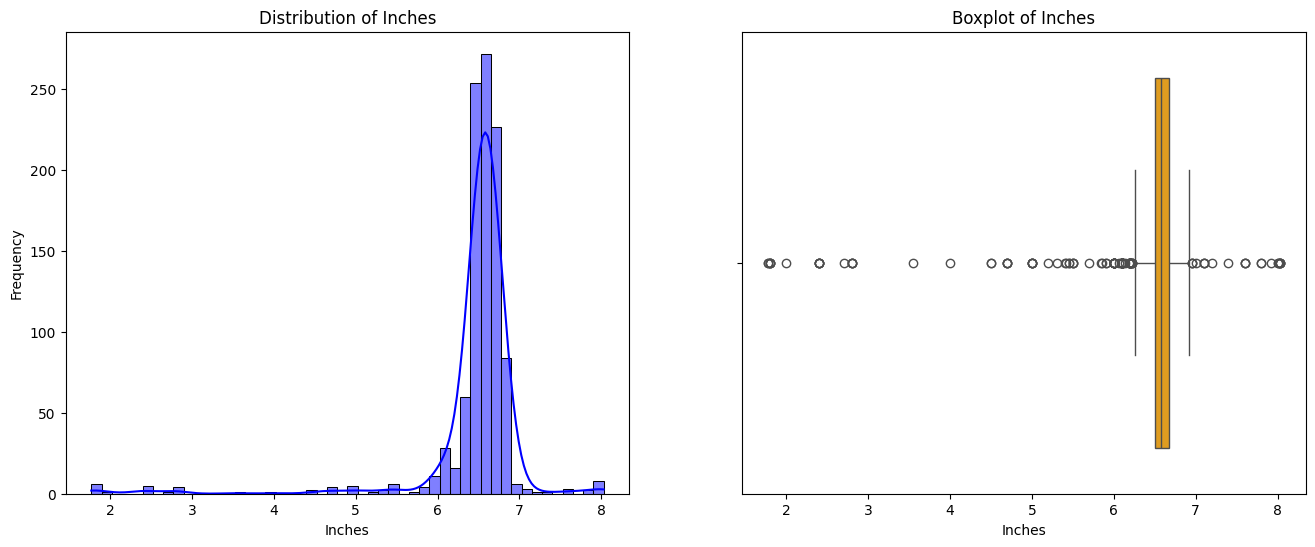


Analyzing 'Resolution_Width':
  Skewness: -4.993
  Kurtosis: 30.516
  Recommended Scaler: RobustScaler (Highly left-skewed, severe outliers)


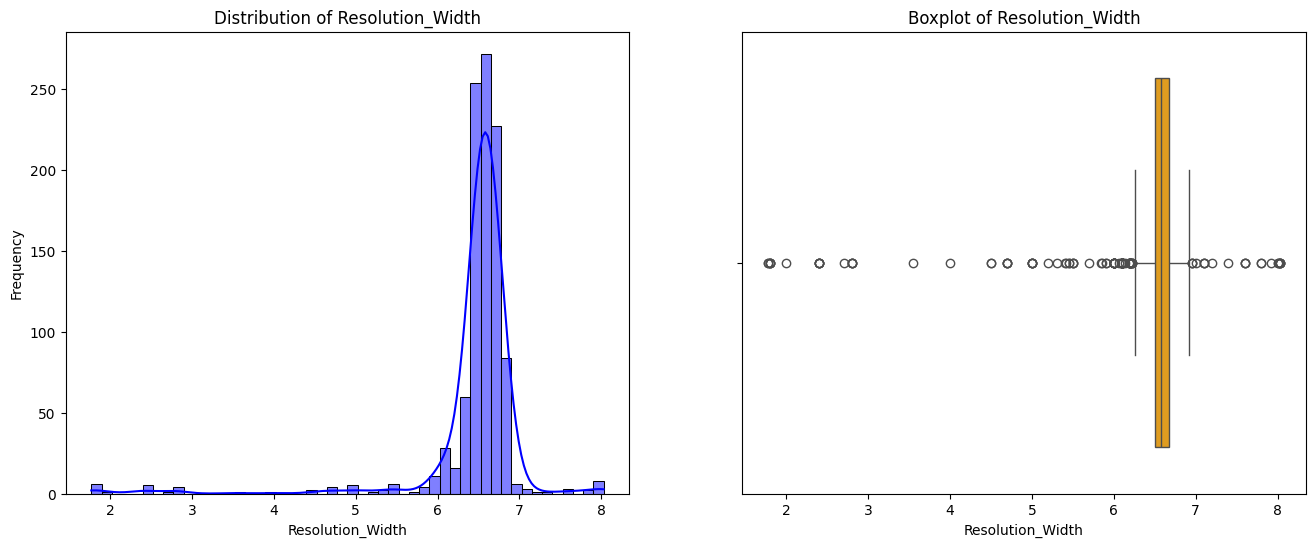


Analyzing 'Resolution_Height':
  Skewness: -1.042
  Kurtosis: 1.807
  Recommended Scaler: MinMaxScaler (Moderate left skew, low kurtosis)


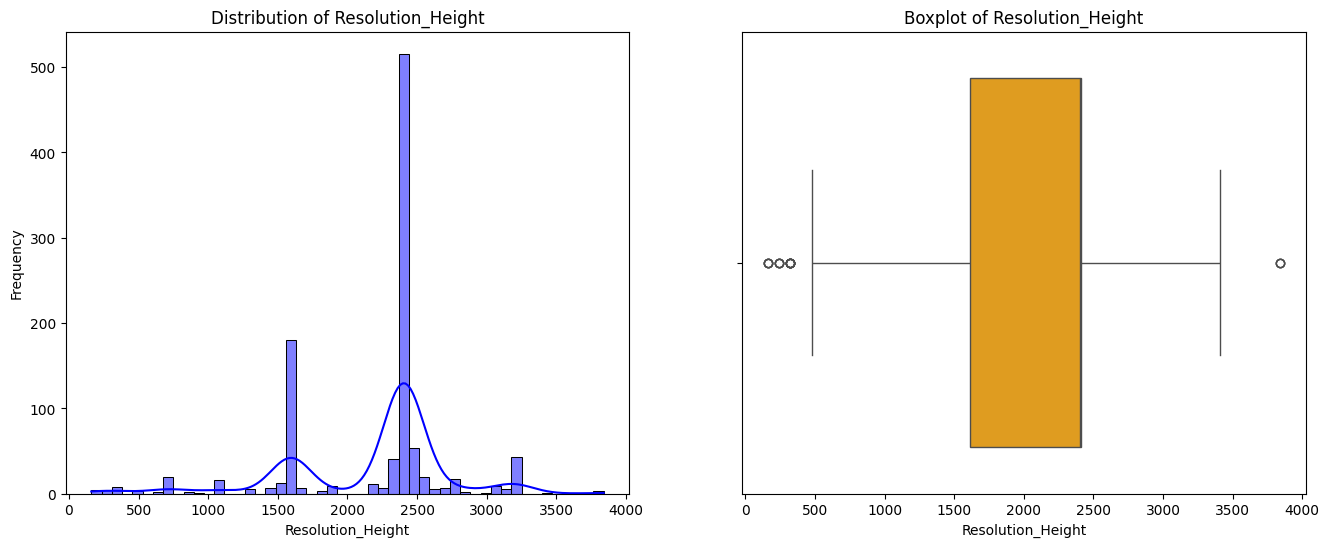


Analyzing 'price':
  Skewness: 6.572
  Kurtosis: 79.300
  Recommended Scaler: Yeo-Johnson (Highly right-skewed, severe outliers)


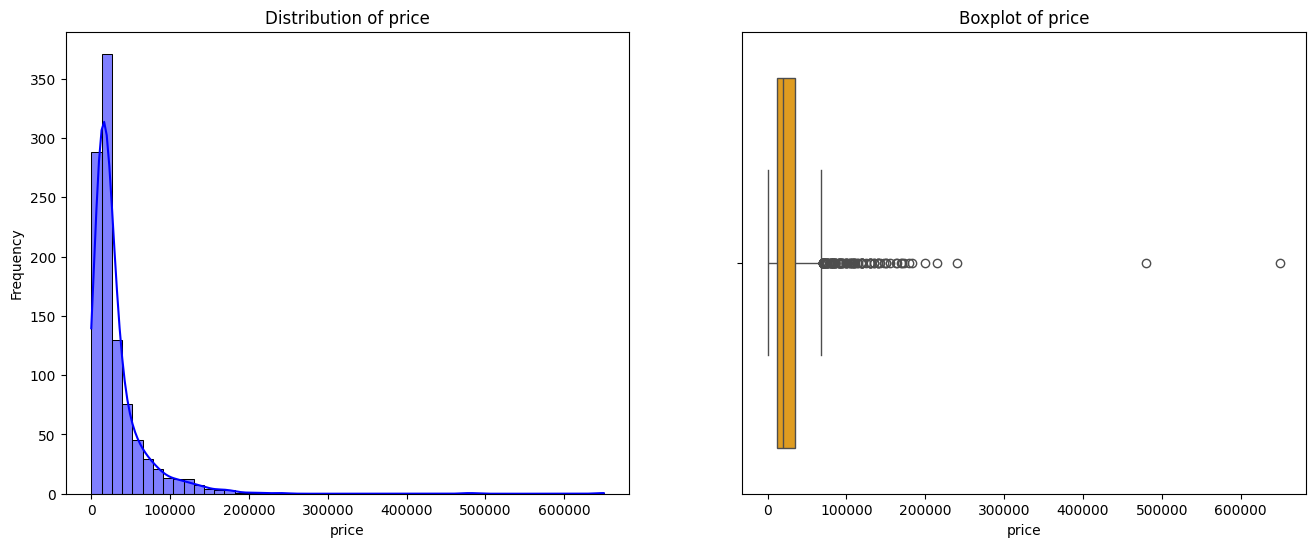

In [205]:
recommendations = analyze_distributions(df,cols_to_transform)

In [213]:
recommendations

{'Inches': 'RobustScaler (Highly left-skewed, severe outliers)',
 'Resolution_Width': 'RobustScaler (Highly left-skewed, severe outliers)',
 'Resolution_Height': 'MinMaxScaler (Moderate left skew, low kurtosis)',
 'price': 'Yeo-Johnson (Highly right-skewed, severe outliers)'}

In [214]:
df = apply_transformations(df, recommendations)


Analyzing 'rating':
  Skewness: -0.617
  Kurtosis: -0.517
  Recommended Scaler: MinMaxScaler (Moderate left skew, low kurtosis)


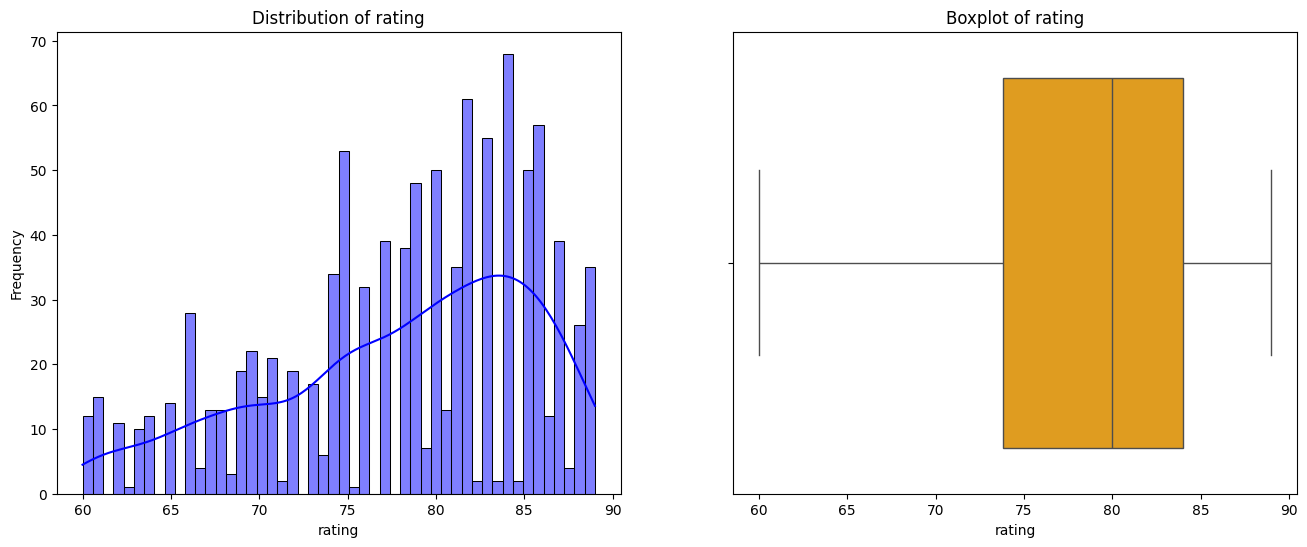

In [218]:
recommendation_rating = analyze_distributions(df,['rating'])

In [219]:
df = apply_transformations(df, recommendation_rating)


Analyzing 'rating':
  Skewness: -0.617
  Kurtosis: -0.517
  Recommended Scaler: MinMaxScaler (Moderate left skew, low kurtosis)


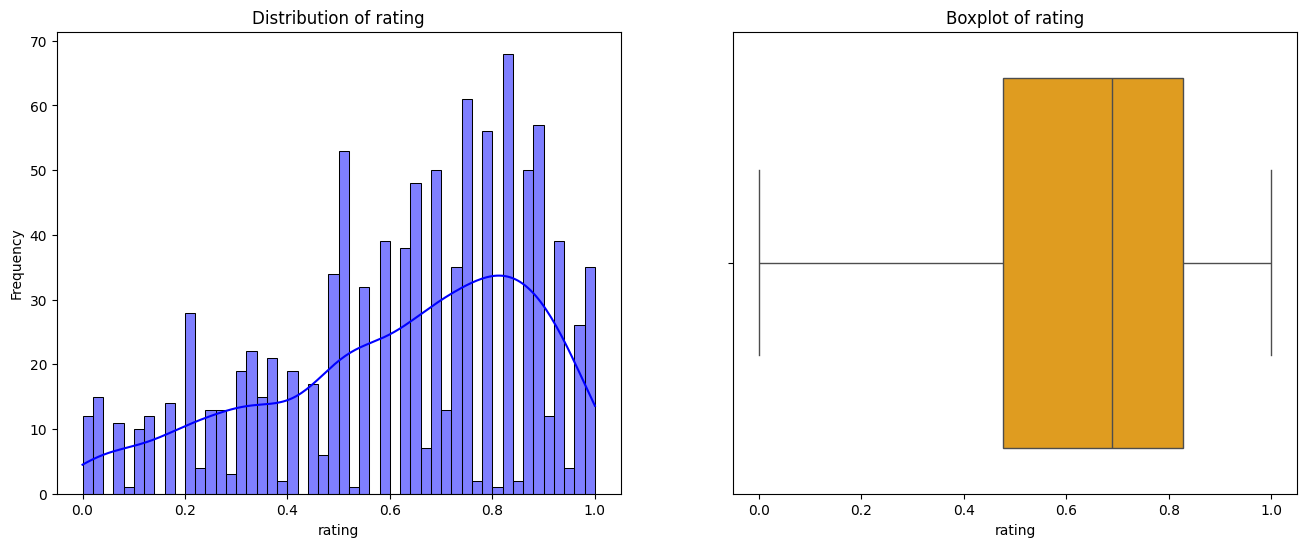

{'rating': 'MinMaxScaler (Moderate left skew, low kurtosis)'}

In [220]:
analyze_distributions(df,['rating'])

In [211]:
#### Final clean dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 88 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   price                                           1020 non-null   int64  
 1   rating                                          1020 non-null   float64
 2   sim (dual/single)                               1020 non-null   int64  
 3   3G                                              1020 non-null   int64  
 4   4G                                              1020 non-null   int64  
 5   5G                                              1020 non-null   int64  
 6   VoLTE                                           1020 non-null   int64  
 7   Vo5G                                            1020 non-null   int64  
 8   NFC                                             1020 non-null   int64  
 9   Wi-Fi                                    

In [210]:
df.drop(columns = ["card","first_rear_mp","front_mp"], inplace = True)

In [221]:
#### Save clean data for further use
from datetime import datetime

# Get current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
df.to_csv(f"/home/jovyan/shield/data/smartphone_attribute_data/processed_smartphone_data_{timestamp}.csv", index=False)

## Modeling

### Anomaly Detection Modeling

    Since there's no historical fraud data, unsupervised learning techniques are most appropriate.
    
        Isolation Forest: Effective for identifying outliers in high-dimensional data.
        

### Anomaly Interpretation and Visualization
    Identify Key Anomalies: Determine which device attributes or combinations of attributes are most indicative of anomalies.
    Visualization: Use visualization techniquesto illustrate the distribution of anomalies and identify patterns.


### Handling Incomplete Data:
    Imputation Techniques: Use techniques like mean imputation, median imputation, or k-nearest neighbors imputation to fill in missing values.
    Robust Algorithms: Select anomaly detection algorithms that are robust to missing data (e.g., Isolation Forest).


    ❌ Is it required to Split (Why Not?)
    
    🚫 If purely unsupervised (No labels):
    
        There's no explicit "ground truth" to measure test set performance, making splitting less useful.
        In this case, you train on the entire dataset and analyze the anomaly scores.
    
    🚫 If anomalies are rare:
    
        A random split could result in no anomalies in the test set, making it meaningless.
        Instead, it's better to detect anomalies in the full dataset and then analyze them.

    

In [225]:
df_processed = pd.read_csv(f"/home/jovyan/shield/data/smartphone_attribute_data/processed_smartphone_data_20250323_082223.csv")

### Isolation forest

In [229]:
# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_processed["Anomaly_Score"] = iso_forest.fit_predict(df_processed)

# -1 means anomaly, 1 means normal
df_processed["Anomaly"] = df_processed["Anomaly_Score"].apply(lambda x: 1 if x == -1 else 0)

# Count anomalies
anomaly_count = df_processed["Anomaly"].sum()
total_count = df_processed.shape[0]
print(f"Total Anomalies Found: {anomaly_count} / {total_count} ({(anomaly_count / total_count) * 100:.2f}%)")

# Display some anomaly rows for inspection
anomalies = df_processed[df_processed["Anomaly"] == 1]


Total Anomalies Found: 51 / 1020 (5.00%)


In [230]:
df_processed.head()

,price,rating,sim (dual/single),3G,4G,5G,VoLTE,Vo5G,NFC,Wi-Fi,...,front_mp_category_>48,front_mp_category_Unknown,Extracted_OS_Other OS,Extracted_OS_iOS,Hz_144.0,Hz_60.0,Hz_90.0,Hz_>150,Anomaly_Score,Anomaly
0,15.297701,1.000000,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,13.432352,0.724138,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,13.091055,0.517241,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,12.922944,0.724138,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,13.835048,0.758621,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [231]:
anomalies

,price,rating,sim (dual/single),3G,4G,5G,VoLTE,Vo5G,NFC,Wi-Fi,...,front_mp_category_>48,front_mp_category_Unknown,Extracted_OS_Other OS,Extracted_OS_iOS,Hz_144.0,Hz_60.0,Hz_90.0,Hz_>150,Anomaly_Score,Anomaly
155,11.048636,0.234483,1,1,1,0,0,0,0,1,...,0,1,1,0,0,1,0,0,-1,1
271,11.408577,0.324138,1,1,1,0,1,0,0,1,...,0,1,1,0,0,1,0,0,-1,1
376,10.932192,0.717241,1,1,1,0,0,0,0,0,...,0,1,1,0,0,1,0,0,-1,1
400,10.221761,0.931034,1,1,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0,-1,1
431,20.342986,0.068966,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,-1,1
439,14.872637,0.406897,1,1,1,1,1,0,1,1,...,0,0,0,1,0,0,0,0,-1,1
473,9.384204,0.324138,1,1,1,0,1,0,0,0,...,0,1,1,0,0,1,0,0,-1,1
477,11.728246,0.675862,1,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,-1,1
481,11.351370,0.820690,1,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,-1,1
486,11.587780,0.324138,1,1,1,0,0,0,0,1,...,0,1,1,0,0,1,0,0,-1,1


In [235]:
 df_processed["Anomaly_Score"].value_counts()

Anomaly_Score
 1    969
-1     51
Name: count, dtype: int64

In [238]:
# Get current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
df_processed.to_csv(f"/home/jovyan/shield/data/smartphone_attribute_data/smartphone_anamoly_detection_{timestamp}.csv", index=False)

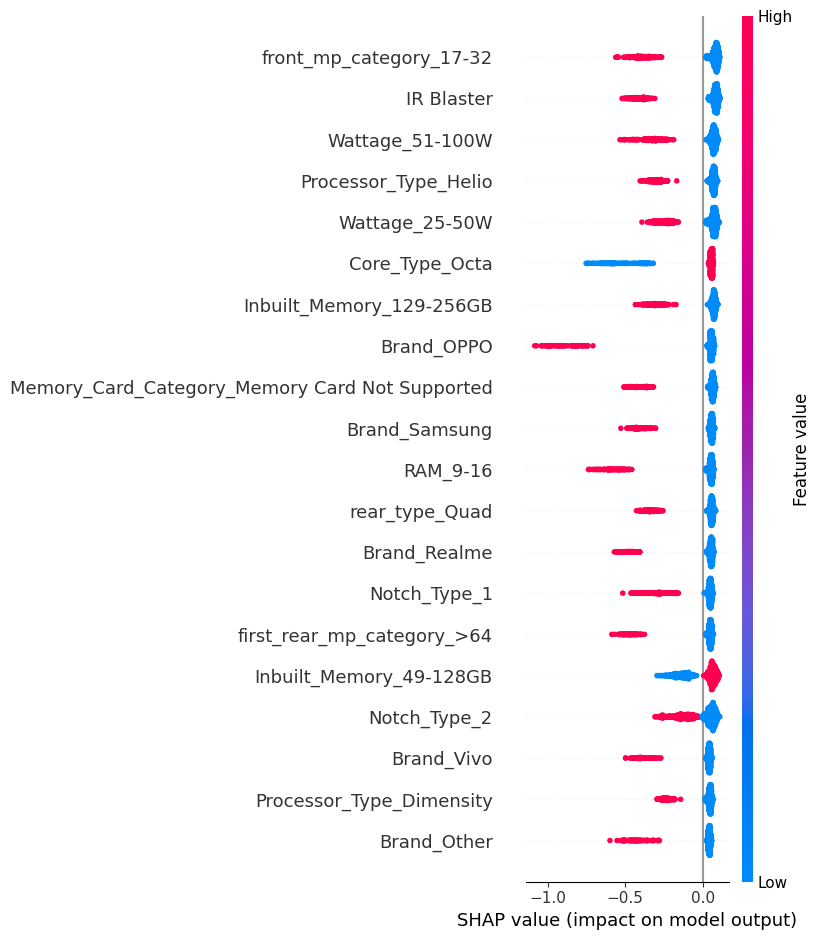

In [237]:
import shap

# Use SHAP to explain the anamolies
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer.shap_values(df_processed)

# Plot SHAP summary
shap.summary_plot(shap_values, df_processed)

### Observations
    1️⃣ High-Impact Features for Anomalies
    
        front_mp_category_17-32 (Front Camera Megapixels 17-32 MP): High values increase anomaly scores, meaning phones with high-resolution front cameras might be unusual compared to the rest of the dataset.
        
        IR Blaster: Phones with an IR blaster tend to be anomalies. This could be because most modern phones no longer have IR blasters.
        
        Wattage_51-100W & Wattage_25-50W: Phones with higher charging wattage (e.g., 51-100W) might be rare or belong to specific brands/models that are different from the rest.
        
        Processor_Type_Helio: Phones using Helio processors may be detected as anomalies—possibly because Helio chips are less common in high-end devices.
    
    2️⃣ Features That Reduce Anomaly Scores
    
        Core_Type_Octa (Octa-Core Processors): Phones with octa-core processors are considered normal, likely because most modern phones have octa-core processors.
        Inbuilt_Memory_49-128GB: Phones with 49-128GB storage are common and reduce anomaly scores, meaning they are seen as normal.
    
    3️⃣ Brand Influence on Anomalies
    
        Brand_OPPO, Brand_Samsung, Brand_Realme, Brand_Vivo
        
            Certain brands like OPPO and Samsung increase anomaly scores, which could indicate:
                A unique pricing strategy.
                Distinctive feature sets that differ from other brands.
                
        Brand_Other
            Phones categorized as "Other" brands are seen as less anomalous. This suggests other brands follow mainstream trends more closely.
    
    4️⃣ Notch Type & Memory Card Support as Anomaly Indicators
    
        Notch_Type_1 & Notch_Type_2: Different notch types impact the anomaly score, possibly indicating certain display designs are rare in the dataset.
        Memory_Card_Category_Memory Card Not Supported: Phones without memory card support are detected as anomalies, possibly because most phones in the dataset do support expandable storage.
    
### Conclusion
    
        Anomalous devices tend to have:
        ✅ High front camera megapixels (17-32 MP).
        ✅ IR Blasters.
        ✅ Memory_Card_Category_Memory Card Not Supported
        ✅ High charging wattage (51-100W).
        ✅ Helio processors.
        ✅ Certain brands like OPPO, Realme, and Samsung.
        ✅ Specific notch types.
    
        Non-anomalous devices tend to have:
        ✅ Octa-core processors.
        ✅ Common storage sizes (49-128GB).
        ✅ Expandable storage support.

### Next steps
    Other algorithms
        Local Outlier Factor (LOF): Detects data points that are significantly different from their neighbors.
        One-Class SVM: Learns a boundary around the "normal" data and identifies points outside that boundary as anomalies.
        Clustering-Based Methods (e.g., DBSCAN, KMeans): Identify clusters of normal behavior and flag data points that don't belong to any cluster as anomalies.
        Autoencoders: Use neural networks to learn a compressed representation of the data and identify anomalies based on reconstruction errors.
        
    Model Selection and Tuning:
            Experiment with different anomaly detection algorithms and compare the performance, use best or ensemble approach
            Tune hyperparameters using techniques like grid search or random search to improve performance
           